<a href="https://colab.research.google.com/github/MarcelLopes7/Machine-Learning-and-Analytics/blob/main/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Machine Learning & Analytics
## Autor: Marcel Antonio Lopes Pereira

## Introdução

Esse MVP consiste na construção de um modelo de machine learning a partir de um dataset com dados de usuários de uma academia de exercícios físicos (Gym Members Exercise Dataset). Para compreensão do dataset em questão, os respectivos atributos são listados a seguir:

**Idade**: Idade do usuário da academia.

**Gênero**: Gênero do usuário da academia (Masculino ou Feminino).

**Peso (kg)**: Peso do usuário em quilogramas.

**Altura (m)**: Altura do usuário em metros.

**BPM Máx**: Frequência cardíaca máxima (batimentos por minuto) durante as sessões de treino.

**BPM Médio**: Frequência cardíaca média durante as sessões de treino.

**BPM Repouso**: Frequência cardíaca em repouso antes do treino.

**Duração da Sessão (horas)**: Duração de cada sessão de treino em horas.

**Calorias Queimadas**: Total de calorias queimadas durante cada sessão.

**Tipo de Treino**: Tipo de treino realizado (por exemplo, Cardio, Força, Yoga, HIIT).

**Percentual de Gordura**: Percentual de gordura corporal do usuário.

**Consumo de Água (litros)**: Consumo diário de água durante os treinos.

**Frequência de Treino (dias/semana)**: Número de sessões de treino por semana.

**Nível de Experiência**: Nível de experiência, de iniciante (1) a especialista (3).

**IMC**: Índice de Massa Corporal, calculado a partir da altura e do peso.

A partir da descrição dos atributos, é possível identificar várias ideias de problemas para ser solucinados. Foi escolhido um problema que consiste na predição do número de calorias queimadas por um usuário. Como o resultado dessa predição é um valor contínuo, esse é um problema de regressão, sendo então de aprendizado supervisionado. Inicialmente, serão explorados esses dados para entender suas distruibuições e correlações. A partir disso, será descrito o procedimento de tratamento e preparação dos mesmos para construção do modelo. Todo o processo de construção do modelo será detalhado, com suas definições e decisões tomadas.

## Importação das bibliotecas

Com os atributos definidos, o código do programa inicia com a importação das bibliotecas python que serão utilizadas nesse projeto. A seguir, são definidas algumas funções que serão utilizadas ao longo do código.

In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import logging
import json
import ast
import joblib

# Importação das bibliotecas do scikitlearn para construção do modelo
from sklearn.linear_model import (LinearRegression, Ridge, Lasso,
                                   ElasticNet)
from sklearn.ensemble import (RandomForestRegressor,
                               GradientBoostingRegressor)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     cross_val_score, KFold,
                                     learning_curve)
from sklearn.preprocessing import (StandardScaler, MinMaxScaler,
                                   OneHotEncoder)
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                              make_scorer)
from sklearn.feature_selection import SelectKBest, f_regression

## Funções utilizadas no programa

São definidas a seguir as funções utilizadas no código do programa para realizar algumas tarefas necessárias no projeto. A primeira delas é a função que realização normalização das colunas do dataset, removendo espaço, quebras de linha e caracteres especiais. Após definida essa função, são definidas funções para realizar a tradução do nome das colunas do inglês para o português.

In [6]:
# Função para normalizar o nome das colunas
# (remover espaços, quebras de linha e caracteres especiais)
def normalizar_coluna(coluna):
    # Remover quebras de linha, espaços extras e
    # caracteres especiais como hifens
    return re.sub(r'[\s\n\-_]+', ' ', coluna).strip().lower()

# Função para renomear as colunas e identificar as
# que não foram traduzidas
def traduzir_colunas(df, colunas_traduzidas):
    colunas_nao_traduzidas = []

    def traduzir_nome_coluna(coluna):
        nome_normalizado = normalizar_coluna(coluna)
        if nome_normalizado in colunas_traduzidas:
            return colunas_traduzidas[nome_normalizado]
        else:
            colunas_nao_traduzidas.append(coluna)  #
            # Adicionar colunas não traduzidas à lista
            return coluna  # Retorna o nome original se não for encontrado

    # Renomear as colunas
    df_traduzido = df.rename(columns=traduzir_nome_coluna)

    if colunas_nao_traduzidas:
        print("Colunas que não foram traduzidas:",
              colunas_nao_traduzidas)
    else:
        print("Todas as colunas foram traduzidas com sucesso.")

    return df_traduzido

Essa função é definida para remover colunas somente com variáveis do tipo string, caso seja necessário utilizar o dataset para realizar análises extritamente númericas, como na criação de uma matriz de correlação.

In [5]:
# Função para remover colunas object
def remover_colunas_object(df):

    # Selecionar apenas colunas que não são do tipo 'object'
    df_numerico = df.select_dtypes(exclude=['object'])

    return df_numerico

Função para construir bloxplots de todas as colunas numéricas em subplots organizados.

In [4]:
def boxplots(df_numerico, num_boxplots_por_linha=2,
             figsize=(12, 6), cor_paleta='viridis'):
    """
    Função para criar boxplots de todas as colunas numéricas em
    subplots organizados.

    Parâmetros:
    - df_numerico: DataFrame contendo apenas colunas numéricas.
    - num_boxplots_por_linha: Número de boxplots por linha
      (padrão é 2).
    - figsize: Tamanho base da figura (padrão é (12, 6)).
    - cor_paleta: Paleta de cores para os boxplots (padrão é
      'viridis').
    """
    # Número de colunas no dataframe
    num_colunas = df_numerico.shape[1]

    # Definir o número de linhas necessárias
    num_linhas = math.ceil(num_colunas / num_boxplots_por_linha)

    # Ajustar o tamanho da figura
    fig, axes = plt.subplots(
        nrows=num_linhas, ncols=num_boxplots_por_linha,
        figsize=(figsize[0], num_linhas * figsize[1])
    )

    # Flatten o array de eixos para simplificar a iteração
    axes = axes.flatten()

    # Definindo o estilo do Seaborn
    sns.set_theme(style="whitegrid")

    # Iterar sobre cada coluna do dataframe e criar um boxplot
    for i, col in enumerate(df_numerico.columns):
        sns.boxplot(x=df_numerico[col], ax=axes[i], palette=cor_paleta)
        axes[i].set_title(f'Boxplot da coluna: {col}', fontsize=12)
        axes[i].set_xlabel('')  # Remover o rótulo do eixo x
        axes[i].set_ylabel('Valores', fontsize=10)
        axes[i].grid(True)  # Adiciona grid para melhor visualização

    # Remover eixos não usados, se houver
    if num_colunas % num_boxplots_por_linha != 0:
        for j in range(num_colunas, len(axes)):
            fig.delaxes(axes[j])

    # Ajustar o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

Essa função constrói histogramas e density plots a partir de atributos selecionados do dataframe

In [3]:
# Função para gerar histogramas e density plots com títulos
# ajustados para nomes longos
def hist_density(df, hist_color='blue', kde_color='red',
                 max_title_length=30):
    colunas_numericas = df.select_dtypes(include='number').columns

    for coluna in colunas_numericas:
        # Ajustar o tamanho do título se for muito longo
        title_hist = f"Histograma de {coluna}"
        title_density = f"Density Plot de {coluna}"

        if len(coluna) > max_title_length:
            title_hist = f"Histograma de\n{coluna}"
            title_density = f"Density Plot de\n{coluna}"

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Gerar o histograma
        sns.histplot(
            df[coluna].dropna(), bins=30, kde=False,
            color=hist_color, ax=axes[0]
        )
        axes[0].set_title(
            title_hist,
            fontsize=12 if len(coluna) > max_title_length else 14
        )
        axes[0].set_xlabel(coluna, fontsize=12)
        axes[0].set_ylabel('Frequência', fontsize=12)

        # Gerar o density plot
        sns.kdeplot(
            df[coluna].dropna(), shade=True, color=kde_color,
            ax=axes[1]
        )
        axes[1].set_title(
            title_density,
            fontsize=12 if len(coluna) > max_title_length else 14
        )
        axes[1].set_xlabel(coluna, fontsize=12)
        axes[1].set_ylabel('Densidade', fontsize=12)

        # Ajustando o layout para evitar sobreposição
        fig.tight_layout(pad=6.0)  # Aumenta o espaçamento entre gráficos

        # Exibir os gráficos
        plt.show()

Essa função aplica a transformação One Hot Enconding em atributos categóricos selecionados como parâmetros de entrada da função

In [2]:
def apply_one_hot_encoding(X_train, X_test, categorical_columns):
    """
    Aplica OneHotEncoding nas colunas categóricas de um conjunto
    de treino e teste.

    Parâmetros:
        X_train (pd.DataFrame): DataFrame de treino.
        X_test (pd.DataFrame): DataFrame de teste.
        categorical_columns (list): Lista com os nomes das colunas
                                    categóricas.

    Retorna:
        X_train_final (pd.DataFrame): DataFrame de treino com codificação
                                      OneHotEncoding.
        X_test_final (pd.DataFrame): DataFrame de teste com codificação
                                     OneHotEncoding.
    """
    # Configurar o OneHotEncoder
    one_hot_encoder = OneHotEncoder(
        sparse_output=False, handle_unknown='ignore'
    )

    # Ajustar o encoder na base de treino
    one_hot_encoder.fit(X_train[categorical_columns])

    # Aplicar o encoder em ambas as bases
    X_train_encoded = one_hot_encoder.transform(
        X_train[categorical_columns]
    )
    X_test_encoded = one_hot_encoder.transform(
        X_test[categorical_columns]
    )

    # Converter os resultados em DataFrames
    column_names = one_hot_encoder.get_feature_names_out(
        categorical_columns
    )
    X_train_encoded = pd.DataFrame(
        X_train_encoded,
        columns=column_names,
        index=X_train.index
    )
    X_test_encoded = pd.DataFrame(
        X_test_encoded,
        columns=column_names,
        index=X_test.index
    )

    # Concatenar com as demais colunas (excluindo as categóricas originais)
    X_train_final = pd.concat(
        [X_train.drop(columns=categorical_columns), X_train_encoded],
        axis=1
    )
    X_test_final = pd.concat(
        [X_test.drop(columns=categorical_columns), X_test_encoded],
        axis=1
    )

    return X_train_final, X_test_final

Essa função realiza a seleção dos melhores atributos para treinamento do modelo

In [7]:
def feature_selection_and_model_evaluation(
    X_train, y_train, X_test, y_test, models, k_values, cv=10,
    scaler=None, random_state=42
):
    """
    Realiza seleção de features, treinamento e avaliação de modelos
    com RMSE e MAE.

    Parâmetros:
    - X_train, y_train: Dados de treino.
    - X_test, y_test: Dados de teste.
    - models: Dicionário com nome e instâncias dos modelos a serem
      avaliados.
    - k_values: Intervalo de valores para o número de features a serem
      selecionadas.
    - cv: Número de folds na validação cruzada.
    - scaler: Instância de um escalonador (ex.: StandardScaler).
    - random_state: Semente para controle de aleatoriedade (padrão 42).

    Retorna:
    - Um dicionário com os resultados completos, os melhores modelos
      para RMSE e MAE, e os melhores atributos selecionados.
    """

    # Configurar logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )

    # Funções para métricas
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    def mae(y_true, y_pred):
        return mean_absolute_error(y_true, y_pred)

    # Scorers
    rmse_scorer = make_scorer(rmse, greater_is_better=False)
    mae_scorer = make_scorer(mae, greater_is_better=False)

    # Resultados
    results = []
    best_rmse, best_mae = float("inf"), float("inf")
    best_k_rmse, best_k_mae = None, None
    best_features_rmse, best_features_mae = None, None
    best_model_rmse, best_model_mae = None, None

    # Guardar colunas originais
    original_columns = X_train.columns

    # Escalonar se necessário
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Loop por modelos e valores de k
    for model_name, model in models.items():
        if hasattr(model, 'random_state'):
            model.set_params(random_state=random_state)

        logging.info(f"Testando modelo: {model_name}")

        for k in k_values:
            # Seleção de features
            selector = SelectKBest(k=k)
            X_train_selected = selector.fit_transform(X_train, y_train)
            selected_features = original_columns[selector.get_support()]
            X_test_selected = X_test[:, selector.get_support()]

            # Validação cruzada para RMSE
            rmse_scores = -cross_val_score(
                model, X_train_selected, y_train, cv=cv,
                scoring=rmse_scorer
            )
            mean_rmse = np.mean(rmse_scores)

            # Validação cruzada para MAE
            mae_scores = -cross_val_score(
                model, X_train_selected, y_train, cv=cv,
                scoring=mae_scorer
            )
            mean_mae = np.mean(mae_scores)

            results.append({
                'model': model_name, 'k': k,
                'mean_rmse': mean_rmse, 'mean_mae': mean_mae,
                'features': selected_features
            })

            logging.info(
                f"  Testado com {k} features. RMSE médio: {mean_rmse:.4f}, "
                f"MAE médio: {mean_mae:.4f}"
            )

            # Atualizar melhor modelo para RMSE
            if mean_rmse < best_rmse:
                best_rmse, best_k_rmse = mean_rmse, k
                best_features_rmse, best_model_rmse = (
                    selected_features, model_name
                )

            # Atualizar melhor modelo para MAE
            if mean_mae < best_mae:
                best_mae, best_k_mae = mean_mae, k
                best_features_mae, best_model_mae = (
                    selected_features, model_name
                )

    # Comparar RMSE e MAE para escolher o melhor modelo
    if best_rmse < best_mae:
        best_model, best_features, best_k = (
            best_model_rmse, best_features_rmse, best_k_rmse
        )
    else:
        best_model, best_features, best_k = (
            best_model_mae, best_features_mae, best_k_mae
        )

    # Treinar o melhor modelo
    best_model_instance = models[best_model]

    best_model_instance.fit(X_train[:, selector.get_support()], y_train)
    y_test_pred = best_model_instance.predict(X_test_selected)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Resultados finais
    final_results = {
        'best_model': best_model, 'best_features': best_features,
        'best_k': best_k, 'test_rmse': test_rmse, 'test_mae': test_mae,
        'detailed_results': results
    }

    return final_results, best_k, best_features

Essa função constrói uma pipeline e avalia o desempenho de diversos modelos de regressão a partir de uma base de treino especificada e de atributos selecionados, utilizando validação cruzada no processo

In [8]:
def evaluate_models_on_training(X_train, y_train, models, scalers,
                                selected_features, cv=10,
                                random_state=42):
    """
    Avalia modelos de regressão com diferentes escalonadores usando
    validação cruzada.

    Parâmetros:
        - X_train: DataFrame com os atributos de treino.
        - y_train: Série ou array com o alvo de treino.
        - models: Dicionário de modelos de regressão (nome -> instância).
        - scalers: Dicionário de escalonadores (nome -> instância ou None).
        - selected_features: Lista com os nomes das features selecionadas.
        - cv: Número de folds para a validação cruzada.
        - random_state: Valor do random_state para garantir
          reprodutibilidade.

    Retorna:
        - results_df: DataFrame com a média e desvio padrão dos
          resultados.
        - all_cv_results_df: DataFrame com todos os resultados de
          validação cruzada (para boxplots).
    """
    results = []
    all_cv_results = []

    for scaler_name, scaler in scalers.items():
        print(f"\nCenário: {scaler_name}")

        # Filtrar os dados apenas com as features selecionadas
        X_train_selected = X_train[selected_features]

        # Escalonar dados, se necessário
        if scaler is not None:
            scaler.fit(X_train_selected)
            X_train_selected = scaler.transform(X_train_selected)

        # Testar cada modelo
        for model_name, model in models.items():
            print(f"\nModelo: {model_name}")

            # Adicionar random_state aos modelos, se não houver
            if random_state is not None:
                if hasattr(model, 'random_state') and \
                   model.random_state is None:
                    model.random_state = random_state

            # Construir a pipeline
            pipeline = Pipeline([('model', model)])

            # Validação cruzada para calcular o RMSE e MAE
            scores_rmse = cross_val_score(
                pipeline, X_train_selected, y_train, cv=cv,
                scoring='neg_mean_squared_error', n_jobs=-1
            )
            scores_mae = cross_val_score(
                pipeline, X_train_selected, y_train, cv=cv,
                scoring='neg_mean_absolute_error', n_jobs=-1
            )

            # Calcular RMSE médio e desvio padrão
            rmse_cv = np.sqrt(-np.mean(scores_rmse))  # Média do RMSE
            rmse_std = np.sqrt(-scores_rmse).std()   # Desvio padrão RMSE

            # Calcular MAE médio e desvio padrão
            mae_cv = -np.mean(scores_mae)  # Média do MAE
            mae_std = scores_mae.std()    # Desvio padrão do MAE

            # Adicionar resultados ao DataFrame
            results.append({
                'Cenário': scaler_name,
                'Modelo': model_name,
                'RMSE CV': rmse_cv,
                'Desvio RMSE': rmse_std,
                'MAE CV': mae_cv,
                'Desvio MAE': mae_std
            })

            # Registrar todos os resultados individuais de validação
            # cruzada (RMSE e MAE)
            for fold_rmse, fold_mae in zip(-scores_rmse, -scores_mae):
                all_cv_results.append({
                    'Cenário': scaler_name,
                    'Modelo': model_name,
                    'RMSE': np.sqrt(fold_rmse),
                    'MAE': fold_mae
                })

            print(f"RMSE CV: {rmse_cv:.4f}, Desvio: {rmse_std:.4f}, "
                  f"MAE CV: {mae_cv:.4f}, Desvio MAE: {mae_std:.4f}")

    # Consolidar resultados em DataFrames
    results_df = pd.DataFrame(results).sort_values(by='RMSE CV')
    all_cv_results_df = pd.DataFrame(all_cv_results)

    return results_df, all_cv_results_df

Essa função constrói gráficos bloxplot para os melhores modelos treinados.

In [9]:
def gerar_graficos_boxplot(all_cv_results_df, cenarios):
    """
    Gera gráficos de boxplot para RMSE e MAE nos diferentes cenários
    fornecidos.

    Parâmetros:
    - all_cv_results_df: DataFrame contendo os resultados da validação
      cruzada com colunas 'Cenário', 'Modelo', 'RMSE' e 'MAE'.
    - cenarios: Lista de strings indicando os diferentes cenários a serem
      plotados.
    """

    # Criar figura para os gráficos de RMSE
    fig_rmse, axes_rmse = plt.subplots(1, len(cenarios), figsize=(
        6 * len(cenarios), 6), sharey=True)

    # Criar figura para os gráficos de MAE
    fig_mae, axes_mae = plt.subplots(1, len(cenarios), figsize=(
        6 * len(cenarios), 6), sharey=True)

    # Para cada cenário, plotar um boxplot separado para RMSE e MAE
    for i, cenario in enumerate(cenarios):
        # Subgráfico para RMSE
        ax_rmse = axes_rmse[i] if len(cenarios) > 1 else axes_rmse

        # Subgráfico para MAE
        ax_mae = axes_mae[i] if len(cenarios) > 1 else axes_mae

        # Filtrar os dados para o cenário atual
        cenario_data = (
            all_cv_results_df[all_cv_results_df['Cenário'] == cenario])

        # Ordenar os modelos por RMSE e pegar os 5 melhores (menores RMSE)
        top_5_models = cenario_data.groupby('Modelo')['RMSE'].mean().nsmallest(
            5).index
        top_5_data = cenario_data[cenario_data['Modelo'].isin(top_5_models)]

        # Plotar o boxplot para os 5 melhores modelos do cenário - RMSE
        sns.boxplot(
            data=top_5_data,
            x='Modelo', y='RMSE', ax=ax_rmse,
            showfliers=False, color='lightblue'
        )
        ax_rmse.set_title(f'Distribuição do RMSE - {cenario}')
        ax_rmse.set_xlabel('Modelos')
        ax_rmse.set_ylabel('RMSE')
        ax_rmse.tick_params(axis='x', rotation=45)

        # Plotar o boxplot para os 5 melhores modelos do cenário - MAE
        sns.boxplot(
            data=top_5_data,
            x='Modelo', y='MAE', ax=ax_mae,
            showfliers=False, color='lightgreen'
        )
        ax_mae.set_title(f'Distribuição do MAE - {cenario}')
        ax_mae.set_xlabel('Modelos')
        ax_mae.set_ylabel('MAE')
        ax_mae.tick_params(axis='x', rotation=45)

    # Ajustar o layout para evitar sobreposição de texto
    fig_rmse.tight_layout()
    fig_mae.tight_layout()

    # Exibir os gráficos
    plt.show()

Essa função constrói curvas de aprendizado para os modelos de Machine Learning selecionados.

In [11]:
def plot_learning_curves(X_train, y_train, models, scalers, selected_features,
                         top_models, cv=10, random_state=42):
    """
    Gera as curvas de aprendizado para os 5 melhores modelos.

    Parâmetros:
        - X_train: DataFrame com os atributos de treino.
        - y_train: Série ou array com o alvo de treino.
        - models: Dicionário com os modelos treinados.
        - scalers: Dicionário de escalonadores.
        - selected_features: Lista com as features selecionadas.
        - top_models: DataFrame com os 5 melhores modelos (filtrado).
        - cv: Número de folds para validação cruzada.
        - random_state: Valor de semente para o random_state (default é 42).
    """
    # Criar figura para os gráficos de RMSE
    fig_rmse, axes_rmse = plt.subplots(1, len(top_models), figsize=(20, 6),
                                       sharey=True)

    # Criar figura para os gráficos de MAE
    fig_mae, axes_mae = plt.subplots(1, len(top_models), figsize=(20, 6),
                                     sharey=True)

    axes_rmse = axes_rmse.ravel()  # Para facilitar a iteração
    axes_mae = axes_mae.ravel()

    # Para cada um dos 5 melhores modelos
    for idx, (_, row) in enumerate(top_models.iterrows()):
        model_name = row['Modelo']
        scaler_name = row['Cenário']

        # Configurar os dados com o escalonador
        scaler = scalers[scaler_name]
        X_train_selected = X_train[selected_features]
        if scaler is not None:
            # Verificar e aplicar o random_state no escalonador, se necessário
            if hasattr(scaler, 'random_state') and scaler.random_state is None:
                scaler.random_state = random_state
            scaler.fit(X_train_selected)
            X_train_selected = scaler.transform(X_train_selected)

        # Obter o modelo
        model = models[model_name]

        # Verificar e aplicar o random_state no modelo, se necessário
        if hasattr(model, 'random_state') and model.random_state is None:
            model.random_state = random_state

        # Calcular a curva de aprendizado
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train_selected, y_train, cv=cv,
            scoring='neg_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 10),
            n_jobs=-1
        )

        # Transformar as pontuações de erro negativo para RMSE
        train_rmse = np.sqrt(-train_scores)
        val_rmse = np.sqrt(-val_scores)

        # Calcular MAE
        train_mae = np.mean(np.abs(train_scores), axis=1)
        val_mae = np.mean(np.abs(val_scores), axis=1)

        # Média e desvio padrão para treino e validação
        train_rmse_mean = train_rmse.mean(axis=1)
        train_rmse_std = train_rmse.std(axis=1)
        val_rmse_mean = val_rmse.mean(axis=1)
        val_rmse_std = val_rmse.std(axis=1)

        # Plotar a curva de aprendizado para RMSE
        ax_rmse = axes_rmse[idx]
        ax_rmse.plot(train_sizes, train_rmse_mean, 'o-', color='blue',
                     label='Erro de Treino (RMSE)')
        ax_rmse.plot(train_sizes, val_rmse_mean, 'o-', color='orange',
                     label='Erro de Validação (RMSE)')
        ax_rmse.fill_between(train_sizes, train_rmse_mean - train_rmse_std,
                             train_rmse_mean + train_rmse_std, color='blue',
                             alpha=0.2)
        ax_rmse.fill_between(train_sizes, val_rmse_mean - val_rmse_std,
                             val_rmse_mean + val_rmse_std, color='orange',
                             alpha=0.2)
        ax_rmse.set_title(f"{model_name}\n{scaler_name} (RMSE)", fontsize=12)
        ax_rmse.set_xlabel("Tamanho do Conjunto de Treino")
        ax_rmse.set_ylabel("RMSE")
        ax_rmse.legend(loc="best")
        ax_rmse.grid(True, linestyle='--', color='gray', alpha=0.5)

        # Plotar a curva de aprendizado para MAE
        ax_mae = axes_mae[idx]
        ax_mae.plot(train_sizes, train_mae, 'o-', color='blue',
                    label='Erro de Treino (MAE)')
        ax_mae.plot(train_sizes, val_mae, 'o-', color='orange',
                    label='Erro de Validação (MAE)')
        ax_mae.fill_between(train_sizes, train_mae - train_mae.std(),
                            train_mae + train_mae.std(), color='blue',
                            alpha=0.2)
        ax_mae.fill_between(train_sizes, val_mae - val_mae.std(),
                            val_mae + val_mae.std(), color='orange',
                            alpha=0.2)
        ax_mae.set_title(f"{model_name}\n{scaler_name} (MAE)", fontsize=12)
        ax_mae.set_xlabel("Tamanho do Conjunto de Treino")
        ax_mae.set_ylabel("MAE")
        ax_mae.legend(loc="best")
        ax_mae.grid(True, linestyle='--', color='gray', alpha=0.5)

    # Ajustar layout
    fig_rmse.tight_layout()
    fig_mae.tight_layout()

    # Exibir os gráficos
    plt.show()


Essa função realiza a otimização de hiperparâmetros para os modelos selecionados

In [12]:
def apply_grid_search_top_5(X_train_final, y_train, best_features, models,
                            scalers, results_df, random_state=42):
    """
    Aplica Grid Search nos 5 melhores modelos selecionados com maior gama
    de hiperparâmetros.

    Parâmetros:
        - X_train_final: DataFrame com os dados de treino.
        - y_train: Série ou array com os valores alvo.
        - best_features: Lista com as melhores features selecionadas.
        - models: Dicionário contendo os modelos.
        - scalers: Dicionário contendo os escalonadores.
        - results_df: DataFrame com os resultados iniciais dos modelos.
        - random_state: Valor para garantir reprodutibilidade (opcional).

    Retorna:
        - DataFrame com os melhores hiperparâmetros, MAE e RMSE de cada
          modelo.
    """
    # Filtrar os 5 melhores modelos com base nas métricas
    top_5_models = results_df.head(5)

    # Lista expandida de hiperparâmetros
    param_grids = {
        'Regressão Linear': {},  # Sem hiperparâmetros para ajustar
        'Lasso': {
            'alpha': np.logspace(-4, 2, 15)  # Intervalo logarítmico entre
                                             # 0.0001 e 100
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200],  # Aumento no número de estimadores
            'learning_rate': [0.01, 0.05, 0.1],  # Mais valores para
                                                # learning_rate
            'max_depth': [3, 5],  # Mais opções para max_depth
            'subsample': [0.7, 0.8, 0.9],  # Parâmetro adicional: subsample
            'min_samples_split': [2, 5],  # Parâmetro adicional:
                                         # min_samples_split
            'min_samples_leaf': [1, 2, 5],  # Parâmetro adicional:
                                           # min_samples_leaf
        }
    }

    # Lista para armazenar os resultados do Grid Search
    grid_search_results = []

    # Iterar pelos 5 melhores modelos
    for _, row in top_5_models.iterrows():
        model_name = row['Modelo']
        scaler_name = row['Cenário']
        print(f"\nAplicando Grid Search no modelo: {model_name} com "
              f"escalonador: {scaler_name}")

        # Configurar dados escalonados
        if scaler_name == 'Atributos Originais':
            X_train_scaled = X_train_final[best_features]
        else:
            scaler = scalers[scaler_name]
            X_train_scaled = scaler.fit_transform(X_train_final[best_features])

        # Recuperar o modelo e o grid de hiperparâmetros
        model = models[model_name]
        param_grid = param_grids.get(model_name, {})

        # Aplicar random_state se o modelo for um tipo que aceita esse
        # parâmetro
        if 'random_state' in model.get_params():
            model.set_params(random_state=random_state)

        # Configurar e executar o Grid Search com múltiplas métricas
        grid_search = GridSearchCV(
            model, param_grid,
            scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
            refit='neg_mean_absolute_error',  # Usar MAE para o melhor modelo
            cv=5, n_jobs=-1, verbose=1
        )
        grid_search.fit(X_train_scaled, y_train)

        # Salvar os melhores resultados (MAE e RMSE)
        best_mae = -grid_search.best_score_  # Negativo porque o GridSearchCV
                                             # usa pontuações negativas
        best_rmse = np.sqrt(-grid_search.cv_results_[
            'mean_test_neg_mean_squared_error'][grid_search.best_index_])

        # Adicionar os resultados à lista
        grid_search_results.append({
            'Modelo': model_name,
            'Cenário': scaler_name,
            'Melhor MAE': best_mae,
            'Melhor RMSE': best_rmse,
            'Melhores Hiperparâmetros': grid_search.best_params_
        })

    # Converter os resultados em DataFrame
    grid_search_results_df = pd.DataFrame(grid_search_results)

    # Exibir os resultados em formato de lista de dicionários
    print("\nResultados:")
    for result in grid_search_results:
        print(result)

    return grid_search_results_df

Esta função constrói curvas de aprendizado após a otimização dos hiperparâmetros

In [13]:
def plot_learning_curves_post_grid_search(X_train, y_train, models,
                                           scalers, selected_features,
                                           grid_search_results_df, cv=10):
    """
    Gera as curvas de aprendizado para os modelos otimizados pelo Grid Search.

    Parâmetros:
        - X_train: DataFrame com os atributos de treino.
        - y_train: Série ou array com o alvo de treino.
        - models: Dicionário com os modelos disponíveis.
        - scalers: Dicionário de escalonadores.
        - selected_features: Lista com as features selecionadas.
        - grid_search_results_df: DataFrame com os resultados do Grid Search
          (modelos otimizados).
        - cv: Número de folds para validação cruzada.
    """
    # Criar figura para os gráficos de RMSE
    fig_rmse, axes_rmse = plt.subplots(1, len(grid_search_results_df),
                                       figsize=(20, 6), sharey=True)

    # Criar figura para os gráficos de MAE
    fig_mae, axes_mae = plt.subplots(1, len(grid_search_results_df),
                                     figsize=(20, 6), sharey=True)

    axes_rmse = axes_rmse.ravel()  # Para facilitar a iteração
    axes_mae = axes_mae.ravel()

    for idx, (_, row) in enumerate(grid_search_results_df.iterrows()):
        model_name = row['Modelo']
        scaler_name = row['Cenário']

        # Converter string em dicionário
        best_params = ast.literal_eval(row['Melhores Hiperparâmetros'])

        # Configurar os dados com o escalonador
        scaler = scalers[scaler_name]
        X_train_selected = X_train[selected_features]
        if scaler is not None:
            scaler.fit(X_train_selected)
            X_train_selected = scaler.transform(X_train_selected)

        # Obter o modelo otimizado e ajustar o random_state, se necessário
        model = models[model_name]
        model.set_params(**best_params) # Atualiza os hiperparâmetros do modelo

        # Adicionar random_state se o modelo suportar
        if hasattr(model, 'random_state') and model.random_state is None:
            model.set_params(random_state=42)

        # Calcular a curva de aprendizado para RMSE
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train_selected, y_train, cv=cv,
            scoring='neg_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
        )
        train_rmse = np.sqrt(-train_scores)
        val_rmse = np.sqrt(-val_scores)

        # Calcular a curva de aprendizado para MAE
        train_sizes_mae, train_scores_mae, val_scores_mae = learning_curve(
            model, X_train_selected, y_train, cv=cv,
            scoring='neg_mean_absolute_error',
            train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
        )
        train_mae = -train_scores_mae
        val_mae = -val_scores_mae

        # Média e desvio padrão para treino e validação (RMSE)
        train_mean_rmse = train_rmse.mean(axis=1)
        train_std_rmse = train_rmse.std(axis=1)
        val_mean_rmse = val_rmse.mean(axis=1)
        val_std_rmse = val_rmse.std(axis=1)

        # Média e desvio padrão para treino e validação (MAE)
        train_mean_mae = train_mae.mean(axis=1)
        train_std_mae = train_mae.std(axis=1)
        val_mean_mae = val_mae.mean(axis=1)
        val_std_mae = val_mae.std(axis=1)

        # Plotar a curva de aprendizado para RMSE
        ax_rmse = axes_rmse[idx]
        ax_rmse.plot(train_sizes, train_mean_rmse, 'o-', color='blue',
                     label='Erro de Treino (RMSE)')
        ax_rmse.plot(train_sizes, val_mean_rmse, 'o-', color='orange',
                     label='Erro de Validação (RMSE)')
        ax_rmse.fill_between(train_sizes, train_mean_rmse - train_std_rmse,
                             train_mean_rmse + train_std_rmse, color='blue',
                             alpha=0.2)
        ax_rmse.fill_between(train_sizes, val_mean_rmse - val_std_rmse,
                             val_mean_rmse + val_std_rmse, color='orange',
                             alpha=0.2)
        ax_rmse.set_title(f"{model_name}\n{scaler_name} (RMSE)", fontsize=12)
        ax_rmse.set_xlabel("Tamanho do Conjunto de Treino")
        ax_rmse.set_ylabel("RMSE")
        ax_rmse.legend(loc="best")
        ax_rmse.grid(True, linestyle='--', color='gray', alpha=0.5)

        # Plotar a curva de aprendizado para MAE
        ax_mae = axes_mae[idx]
        ax_mae.plot(train_sizes_mae, train_mean_mae, 'o-', color='blue',
                    label='Erro de Treino (MAE)')
        ax_mae.plot(train_sizes_mae, val_mean_mae, 'o-', color='orange',
                    label='Erro de Validação (MAE)')
        ax_mae.fill_between(train_sizes_mae, train_mean_mae - train_std_mae,
                            train_mean_mae + train_std_mae, color='blue',
                            alpha=0.2)
        ax_mae.fill_between(train_sizes_mae, val_mean_mae - val_std_mae,
                            val_mean_mae + val_std_mae, color='orange',
                            alpha=0.2)
        ax_mae.set_title(f"{model_name}\n{scaler_name} (MAE)", fontsize=12)
        ax_mae.set_xlabel("Tamanho do Conjunto de Treino")
        ax_mae.set_ylabel("MAE")
        ax_mae.legend(loc="best")
        ax_mae.grid(True, linestyle='--', color='gray', alpha=0.5)

    # Ajustar layout
    fig_rmse.tight_layout()
    fig_mae.tight_layout()

    # Exibir os gráficos
    plt.show()

Essa função realiza o teste dos modelos com dados não vistos

In [14]:
def testar_modelos_otimizados(
    X_train, y_train, X_test_final, y_test, optimized_results_df, models,
    scalers, best_features, random_state=42
):
    """
    Testa os modelos otimizados com base no conjunto de teste,
    calculando as métricas RMSE e MAE.

    Parâmetros:
        - X_train: DataFrame com os dados de treino (atributos).
        - y_train: Série ou array com o alvo de treino.
        - X_test_final: DataFrame com os dados de teste (atributos).
        - y_test: Série ou array com o alvo de teste.
        - optimized_results_df: DataFrame contendo os resultados dos modelos
        otimizados.
        - models: Dicionário contendo os modelos treinados.
        - scalers: Dicionário de escalonadores para os modelos.
        - best_features: Lista com as melhores features selecionadas para o
        modelo.
        - random_state: Valor fixo para garantir a reprodutibilidade.

    Retorna:
        - DataFrame com os resultados de RMSE e MAE dos modelos no conjunto
        de teste.
    """
    # Lista para armazenar os resultados de teste
    test_results = []

    # Preparar a base de teste com o mesmo escalonamento aplicado aos dados
    # de treino
    for _, row in optimized_results_df.iterrows():
        model_name = row['Modelo']
        scaler_name = row['Cenário']

        # Converter a string de hiperparâmetros para um dicionário
        best_params = ast.literal_eval(row['Melhores Hiperparâmetros'])

        print(f"\nTestando o modelo: {model_name} com escalonador: "
              f"{scaler_name}")

        # Configurar o escalonador
        if scaler_name == 'Atributos Originais':
            X_test_scaled = X_test_final[best_features]
        else:
            scaler = scalers[scaler_name]
            X_test_scaled = scaler.transform(X_test_final[best_features])

        # Recuperar o modelo
        model = models[model_name]

        # Atualizar parâmetros se o modelo aceita random_state
        model_params = model.get_params()
        if 'random_state' in model_params:
            best_params['random_state'] = random_state

        # Configurar o modelo com os melhores parâmetros
        model.set_params(**{k: v for k, v in best_params.items() if k in
                             model_params})

        # Escalonar os dados de treino
        if scaler_name == 'Atributos Originais':
            X_train_scaled = X_train[best_features]
        else:
            scaler = scalers[scaler_name]
            X_train_scaled = scaler.fit_transform(X_train[best_features])

        # Treinar o modelo nos dados de treino
        model.fit(X_train_scaled, y_train)

        # Fazer previsões na base de teste
        y_pred = model.predict(X_test_scaled)

        # Calcular o RMSE e o MAE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        # Armazenar os resultados
        test_results.append({
            'Modelo': model_name,
            'Cenário': scaler_name,
            'RMSE no Teste': rmse,
            'MAE no Teste': mae
        })

    # Converter os resultados para um DataFrame para visualização
    test_results_df = pd.DataFrame(test_results)

    # Exibir os resultados dos modelos no conjunto de teste
    return test_results_df


Essa função plota um gráfico comparativo dos resultados dos modelos com a base de teste

In [15]:
def plot_model_performance(test_results_df):
    """
    Plota os gráficos de desempenho (RMSE e MAE)
    dos modelos no conjunto de teste.

    Parâmetros:
    - test_results_df: DataFrame com os resultados de RMSE e MAE
    para os modelos.

    """
    # Plotar desempenho dos modelos no conjunto de teste (RMSE)
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=test_results_df, x='Modelo', y='RMSE no Teste', hue='Cenário',
        palette='viridis'
    )
    plt.title('Comparação de RMSE no Conjunto de Teste', fontsize=14)
    plt.ylabel('RMSE', fontsize=12)
    plt.xlabel('Modelos', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Cenário', fontsize=10)
    plt.tight_layout()
    plt.show()

    # Plotar desempenho dos modelos no conjunto de teste (MAE)
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=test_results_df, x='Modelo', y='MAE no Teste', hue='Cenário',
        palette='viridis'
    )
    plt.title('Comparação de MAE no Conjunto de Teste', fontsize=14)
    plt.ylabel('MAE', fontsize=12)
    plt.xlabel('Modelos', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Cenário', fontsize=10)
    plt.tight_layout()
    plt.show()

Essa função treino o modelo escolhido em todo o dataset disponível e exibe os resultados

In [16]:
def treinar_modelo_mais_eficiente(
    test_results_df, optimized_results_df, X_train_final, y_train,
    X_test_final, y_test, models, scalers, best_features, random_state=42
):
    """
    Treina o modelo com menor RMSE a partir do DataFrame de resultados de teste.

    Parâmetros:
        test_results_df: DataFrame com os resultados de RMSE e MAE
                         dos modelos no conjunto de teste.
        optimized_results_df: DataFrame com os melhores hiperparâmetros
                              de cada modelo.
        X_train_final: DataFrame com os dados de treino (atributos).
        y_train: Série ou array com o alvo de treino.
        X_test_final: DataFrame com os dados de teste (atributos).
        y_test: Série ou array com o alvo de teste.
        models: Dicionário contendo os modelos treinados.
        scalers: Dicionário de escalonadores para os modelos.
        best_features: Lista com as melhores features selecionadas
                       para o modelo.
        random_state: Valor fixo para garantir a reprodutibilidade (padrão 42).

    Retorna:
        best_model: O modelo treinado com o melhor desempenho.
        cv_rmse_mean: O RMSE médio na validação cruzada.
        cv_mae_mean: O MAE médio na validação cruzada.
    """
    # Escolher o modelo com menor RMSE a partir do test_results_df
    best_model_row = test_results_df.sort_values(by='RMSE no Teste').iloc[0]

    # Extrair o nome do modelo e o nome do escalonador (cenário)
    best_model_name = best_model_row['Modelo']
    best_scaler_name = best_model_row['Cenário']

    print(f"\nModelo escolhido: {best_model_name} com escalonador: "
          f"{best_scaler_name}")

    # Buscar os melhores hiperparâmetros no optimized_results_df
    best_params_row = optimized_results_df[
        (optimized_results_df['Modelo'] == best_model_name) &
        (optimized_results_df['Cenário'] == best_scaler_name)
    ]

    # Extrair os melhores hiperparâmetros
    best_params = best_params_row['Melhores Hiperparâmetros'].values[0]

    # Verificar se os melhores hiperparâmetros são uma string e tentar
    # convertê-los para um dicionário
    if isinstance(best_params, str):
        best_params = ast.literal_eval(best_params)  # Converte a string
    # para um dicionário

    # Exibir os melhores hiperparâmetros
    print(f"\nMelhores Hiperparâmetros encontrados: {best_params}")

    # Combinar os conjuntos de treino e teste para criar o dataset completo
    X_full = pd.concat([X_train_final, X_test_final])
    y_full = pd.concat([y_train, y_test])

    # Configurar o escalonador e os dados
    if best_scaler_name == 'Atributos Originais':
        X_full_scaled = X_full[best_features]  # Dados sem escalonamento
    else:
        scaler = scalers[best_scaler_name]
        X_full_scaled = scaler.fit_transform(X_full[best_features])

    # Recuperar o modelo escolhido
    best_model = models[best_model_name]

    # Aplicar os melhores hiperparâmetros ao modelo
    best_model.set_params(**best_params)  # Aqui, aplicamos os melhores
    # hiperparâmetros extraídos

    # Treinar o modelo com o dataset completo
    best_model.fit(X_full_scaled, y_full)

    print(f"\nModelo {best_model_name} treinado com sucesso nos dados "
          f"completos com os seguintes hiperparâmetros:")
    print(best_params)

    # Avaliar o modelo usando validação cruzada para obter métricas finais
    cv_rmse_scores = cross_val_score(
        best_model, X_full_scaled, y_full, cv=10,
        scoring='neg_mean_squared_error'
    )
    cv_rmse_mean = np.sqrt(-cv_rmse_scores.mean())

    cv_mae_scores = cross_val_score(
        best_model, X_full_scaled, y_full, cv=10,
        scoring='neg_mean_absolute_error'
    )
    cv_mae_mean = -cv_mae_scores.mean()

    print(f"\nDesempenho final do modelo {best_model_name}:")
    print(f"RMSE médio (validação cruzada): {cv_rmse_mean:.2f}")
    print(f"MAE médio (validação cruzada): {cv_mae_mean:.2f}")

    # Salvar o modelo final para uso futuro
    joblib.dump(best_model, 'modelo_final.pkl')
    print("\nModelo salvo como 'modelo_final.pkl'")

    # Retornar o modelo treinado e as métricas finais
    return best_model, cv_rmse_mean, cv_mae_mean

Essa função aplica o One Hot Encoding nos atributos categóricos de novos dados que devem ser utilizados como base de previsão a partir do modelo treinado

In [17]:
def apply_one_hot_encoding_for_new_data(X_new, categorical_columns,
                                         ohe=None):
    """
    Aplica OneHotEncoding nas colunas categóricas de novos dados.

    Parâmetros:
        X_new (pd.DataFrame): DataFrame com os novos dados a serem
        codificados.
        categorical_columns (list): Lista com os nomes das colunas
        categóricas.
        ohe (OneHotEncoder, opcional): OneHotEncoder ajustado na base de
        treino. Se None, será criado um novo.

    Retorna:
        X_new_final (pd.DataFrame): DataFrame de novos dados com codificação
        OneHotEncoding aplicada.
        ohe (OneHotEncoder): O OneHotEncoder ajustado, para reutilização
        futura.
    """
    # Se o encoder não for passado, criaremos um novo e ajustaremos ao
    # conjunto de treino
    if ohe is None:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        ohe.fit(X_new[categorical_columns])  # Ajusta o encoder na base de
        # novos dados

    # Aplicar o encoder nos novos dados
    X_new_encoded = ohe.transform(X_new[categorical_columns])

    # Converter os resultados em DataFrame
    column_names = ohe.get_feature_names_out(categorical_columns)
    X_new_encoded_df = pd.DataFrame(X_new_encoded, columns=column_names,
                                    index=X_new.index)

    # Concatenar com as outras colunas não categóricas
    X_new_final = pd.concat([X_new.drop(columns=categorical_columns),
                             X_new_encoded_df], axis=1)

    return X_new_final, ohe


Essa função aplica transformação nos atributos dos novos dados para a mesma base de que foi utilizada no treinamento do modelo de previsão


In [18]:
def apply_scaler_for_new_data(X_new, scaler, best_features):
    """
    Aplica o escalonamento nos novos dados considerando apenas as
    "best_features".

    Parâmetros:
        X_new (pd.DataFrame): DataFrame com os novos dados a serem
        escalonados.
        scaler (Scaler): O escalonador ajustado (StandardScaler,
        MinMaxScaler, etc.).
        best_features (list): Lista com as melhores features selecionadas
        no treinamento.

    Retorna:
        X_new_scaled (pd.DataFrame): DataFrame com as "best_features"
        escalonadas.
    """
    # Filtrar os dados para conter apenas as melhores features
    X_new_filtered = X_new[best_features]

    # Reajustar o escalonador apenas para as "best_features"
    scaler.fit(X_new_filtered)

    # Aplicar o escalonamento
    X_new_scaled = scaler.transform(X_new_filtered)

    # Converter o resultado para DataFrame
    X_new_scaled_df = pd.DataFrame(X_new_scaled, columns=best_features,
                                   index=X_new.index)

    return X_new_scaled_df

## Análise Exploratória dos Dados



### Análises preliminares

O dataset é importado para o notebook e convertido em dataframe. Em seguida, são exibidas as primeiras linhas do dataframe.

In [19]:
# URL de importação do dataset
url = (
    "https://raw.githubusercontent.com/MarcelLopes7/"
    "Machine-Learning---Analytics/refs/heads/main/"
    "gym_members_exercise_tracking.csv"
)

# Leitura do arquivo
dataframe = pd.read_csv(url)

# Visualização de todas as colunas do dataframe
pd.set_option(
    'display.max_columns', None
)

In [20]:
# Exibição das primeiras linhas do dataset
dataframe.head(10)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
5,56,Female,58.0,1.68,168,156,74,1.59,1116.0,HIIT,15.5,2.7,5,3,20.55
6,36,Male,70.3,1.72,174,169,73,1.49,1385.0,Cardio,21.3,2.3,3,2,23.76
7,40,Female,69.7,1.51,189,141,64,1.27,895.0,Cardio,30.6,1.9,3,2,30.57
8,28,Male,121.7,1.94,185,127,52,1.03,719.0,Strength,28.9,2.6,4,2,32.34
9,28,Male,101.8,1.84,169,136,64,1.08,808.0,Cardio,29.7,2.7,3,1,30.07


In [21]:
# Exibição das últimas linhas do dataset
dataframe.tail(10)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
963,57,Female,43.8,1.75,180,160,73,1.39,1001.0,Cardio,25.1,1.7,2,1,14.30
964,56,Female,64.2,1.69,190,137,61,1.99,1227.0,Cardio,19.6,2.7,5,3,22.48
965,23,Female,44.1,1.62,196,122,58,0.58,354.0,Yoga,25.7,2.7,2,1,16.80
966,23,Male,87.3,1.91,164,129,58,1.87,1327.0,HIIT,11.8,3.5,5,3,23.93
967,20,Male,55.0,1.60,172,168,67,1.12,1035.0,Yoga,24.0,3.2,4,2,21.48
968,24,Male,87.1,1.74,187,158,67,1.57,1364.0,Strength,10.0,3.5,4,3,28.77
969,25,Male,66.6,1.61,184,166,56,1.38,1260.0,Strength,25.0,3.0,2,1,25.69
970,59,Female,60.4,1.76,194,120,53,1.72,929.0,Cardio,18.8,2.7,5,3,19.50
971,32,Male,126.4,1.83,198,146,62,1.10,883.0,HIIT,28.2,2.1,3,2,37.74
972,46,Male,88.7,1.63,166,146,66,0.75,542.0,Strength,28.8,3.5,2,1,33.38


In [22]:
# Mostra as dimensões do dataframe
dataframe.shape

(973, 15)

In [23]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [24]:
# Identificar colunas categóricas (tipo object ou categóricas)
categorical_columns = dataframe.select_dtypes(
    include=['object', 'category']).columns

# Contar e exibir o número de classes únicas para cada coluna categórica
for col in categorical_columns:
    num_classes = dataframe[col].nunique()
    print(f"A coluna '{col}' possui {num_classes} classe(s).")

A coluna 'Gender' possui 2 classe(s).
A coluna 'Workout_Type' possui 4 classe(s).


O dataset possui 973 linhas e 15 colunas, representados os atributos. Dentre essas colunas, 13 são númericas e 2 são catergóricas (Gênero e Tipo de Treino). O atributo Gender possui 2 classes ( Male e Female) e o atributo Workout_Type possui 4 classes (HIIT, Strenght, Yoga e Cardio).

Para facilitar a visualização das informações no mesmo idioma desse projeto, é necessário realizar a tradução da nomenclatura dos atributos no dataframe. São definidos os nomes originais das colunas com suas respectivas traduções. Em seguida, a função de tradução é chamada.

In [25]:
# Dicionário atualizado com as colunas que estavam com formatações diferentes
colunas_traduzidas = {
    "Age": "Idade",
    "Gender": "Gênero",
    "Weight (kg)": "Peso (kg)",
    "Height (m)": "Altura (m)",
    "Max_BPM": "BPM Máx",
    "Avg_BPM": "BPM Médio",
    "Resting_BPM": "BPM Repouso",
    "Session_Duration (hours)": "Duração da Sessão (horas)",
    "Calories_Burned": "Calorias Queimadas",
    "Workout_Type": "Tipo de Treino",
    "Fat_Percentage": "Percentual de Gordura",
    "Water_Intake (liters)": "Consumo de Água (litros)",
    "Workout_Frequency (days/week)": "Frequência de Treino (dias/semana)",
    "Experience_Level": "Nível de Experiência",
    "BMI": "IMC",
}

# Normalizar dicionário de tradução
colunas_traduzidas_normalizado = {
    normalizar_coluna(k): v for k, v in colunas_traduzidas.items()
}

# Aplicar a função ao dataframe
dataframe = traduzir_colunas(dataframe,
                              colunas_traduzidas_normalizado)

Todas as colunas foram traduzidas com sucesso.


In [26]:
# Mapeamento das traduções
translation_map = {
    'Male': 'Masculino',
    'Female': 'Feminino',
    'Cardio': 'Cardio',  # "Cardio" permanece igual
    'Strength': 'Força',
    'Hiit': 'HIIT',
    'Yoga': 'Yoga'
}

# Traduzir linha por linha
for col in dataframe.columns:
    dataframe[col] = dataframe[col].apply(lambda x: translation_map.get(x, x))

dataframe.head(15)

,Idade,Gênero,Peso (kg),Altura (m),BPM Máx,BPM Médio,BPM Repouso,Duração da Sessão (horas),Calorias Queimadas,Tipo de Treino,Percentual de Gordura,Consumo de Água (litros),Frequência de Treino (dias/semana),Nível de Experiência,IMC
0,56,Masculino,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Feminino,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Feminino,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Masculino,53.2,1.70,190,164,56,0.59,532.0,Força,28.8,2.1,3,1,18.41
4,38,Masculino,46.1,1.79,188,158,68,0.64,556.0,Força,29.2,2.8,3,1,14.39
5,56,Feminino,58.0,1.68,168,156,74,1.59,1116.0,HIIT,15.5,2.7,5,3,20.55
6,36,Masculino,70.3,1.72,174,169,73,1.49,1385.0,Cardio,21.3,2.3,3,2,23.76
7,40,Feminino,69.7,1.51,189,141,64,1.27,895.0,Cardio,30.6,1.9,3,2,30.57
8,28,Masculino,121.7,1.94,185,127,52,1.03,719.0,Força,28.9,2.6,4,2,32.34
9,28,Masculino,101.8,1.84,169,136,64,1.08,808.0,Cardio,29.7,2.7,3,1,30.07


Após a tradução, dos nomes dos atributos e das classes, um resumo estatístico do dataset pode ser visualização para extração de algumas informações sobre a distribuição dos dados.

In [27]:
# Resumo estatístico do dataframe
dataframe.describe()

,Idade,Peso (kg),Altura (m),BPM Máx,BPM Médio,BPM Repouso,Duração da Sessão (horas),Calorias Queimadas,Percentual de Gordura,Consumo de Água (litros),Frequência de Treino (dias/semana),Nível de Experiência,IMC
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,24.976773,2.626619,3.321686,1.809866,24.912127
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,6.259419,0.600172,0.913047,0.739693,6.660879
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.320000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,3.000000,1.000000,20.110000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,26.200000,2.600000,3.000000,2.000000,24.160000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,29.300000,3.100000,4.000000,2.000000,28.560000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,49.840000


A partir do resumo estatístico do dataset, é possível extrair algumas informações relevantes:


*   Todos os atributos possuem valores preenchidos em todas as linhas, de forma que não será necessário considerar a exclusão de linhas com dados faltantes.
*   Como não há valores mínimos iguais a zero, pode-se concluir que com todos os dados preenchidos, não há valores nulos no dataset. Um comando a seguir comprova essa afirmação.



In [28]:
dataframe.isnull().sum()

,0
Idade,0
Gênero,0
Peso (kg),0
Altura (m),0
BPM Máx,0
BPM Médio,0
BPM Repouso,0
Duração da Sessão (horas),0
Calorias Queimadas,0
Tipo de Treino,0


Como o dataframe não possui valores nulos, não será necessário um tratamento dos dados em relação a essa questão.


### Análises gráficas


Após essa verificação, são gerados gráficos bloxplot para entender a distribuição dos dados em cada atributo.

In [29]:
# Criando um novo dataframe com as colunas númericas
df_numerico = remover_colunas_object(dataframe)

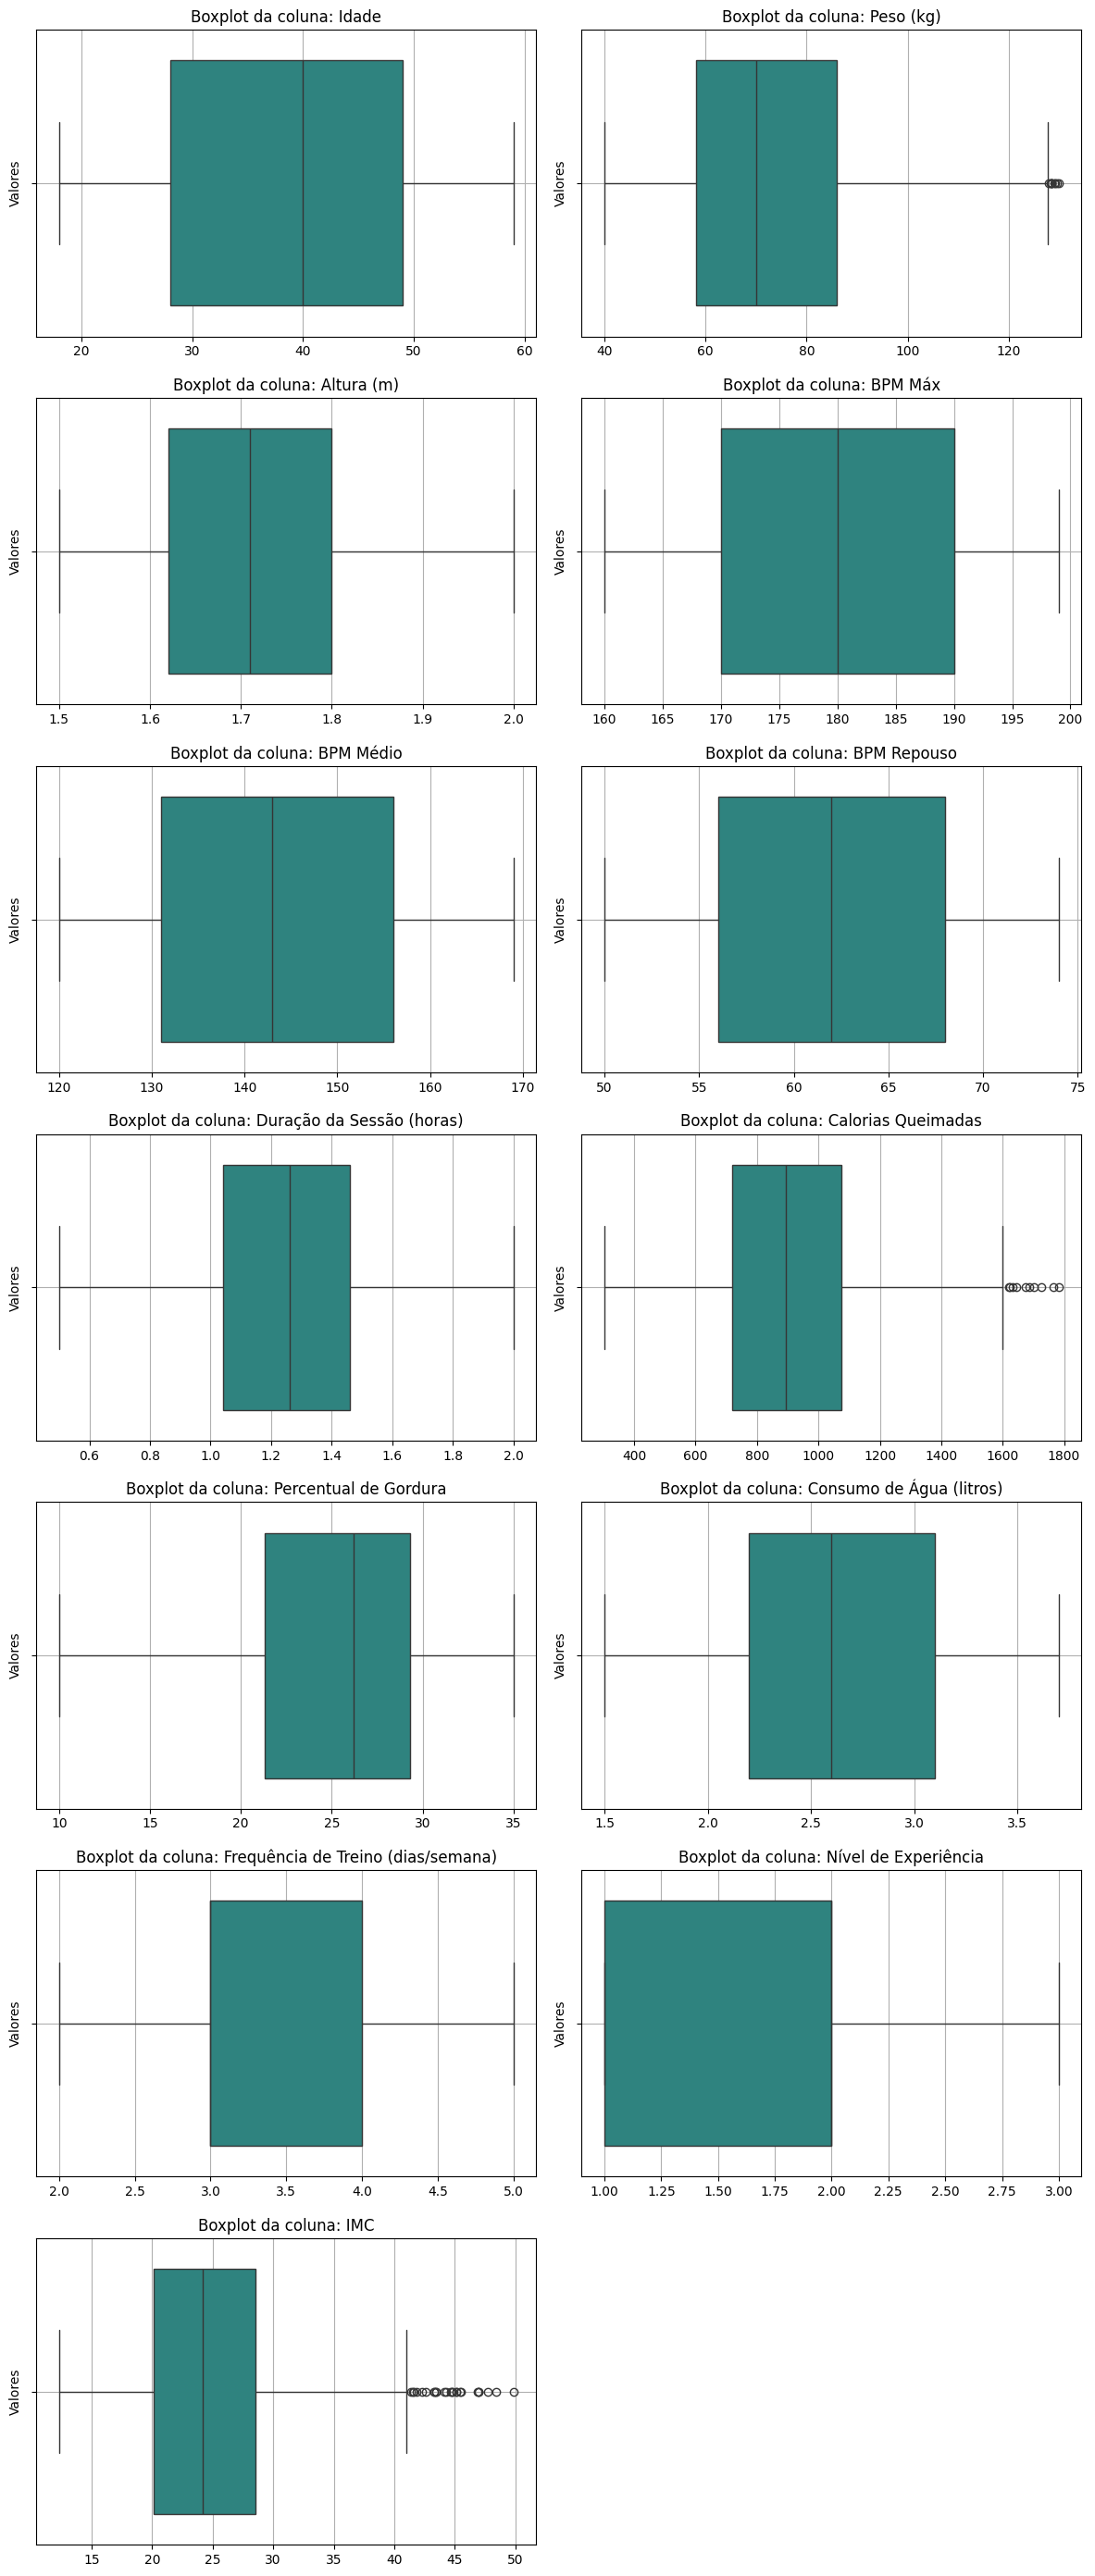

In [30]:
# Chamada da função para plotar os boxplots
boxplots(df_numerico, 2, (12,4))

Após exploração dos atributos por meio da visualização das distribuições em boxplots, verificou-se a presença de outliers em três deles: Peso (kg), Calorias Queimadas (atributo alvo) e IMC.
Como esses dados são necessários para a modelagem do problema, não serão descartados. Desse modo, será necessária a implementação de modelos mais robustos de forma que os outliers não influenciem significamente nos resultados.

São gerados também gráficos para entender a tipo de distribuição desses dados.

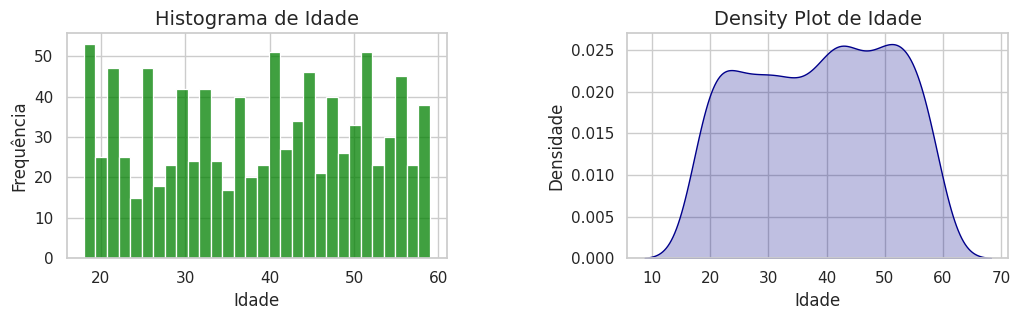

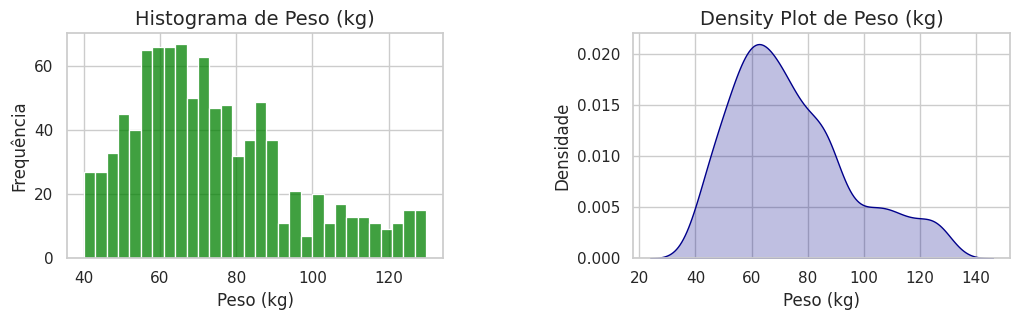

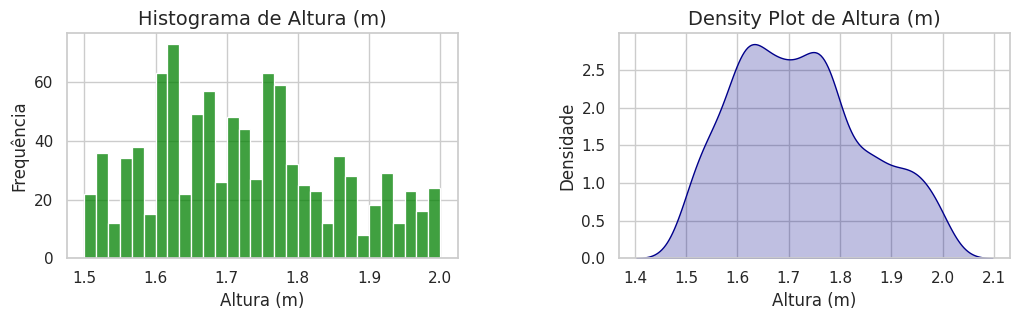

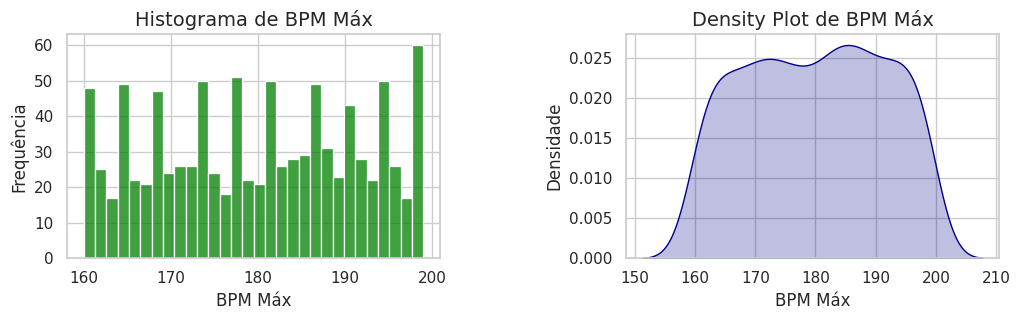

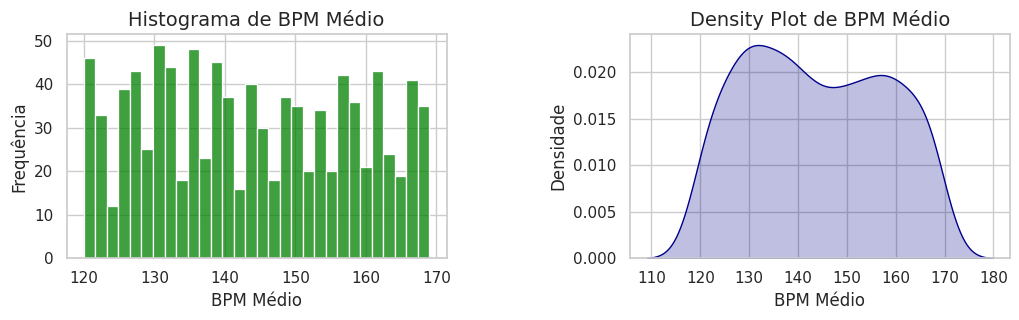

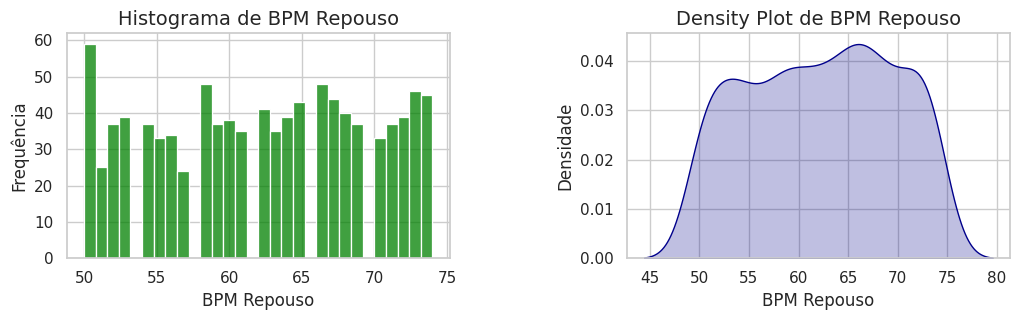

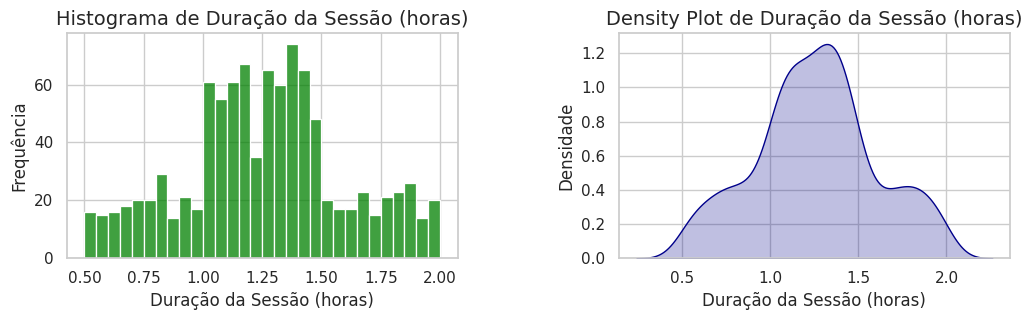

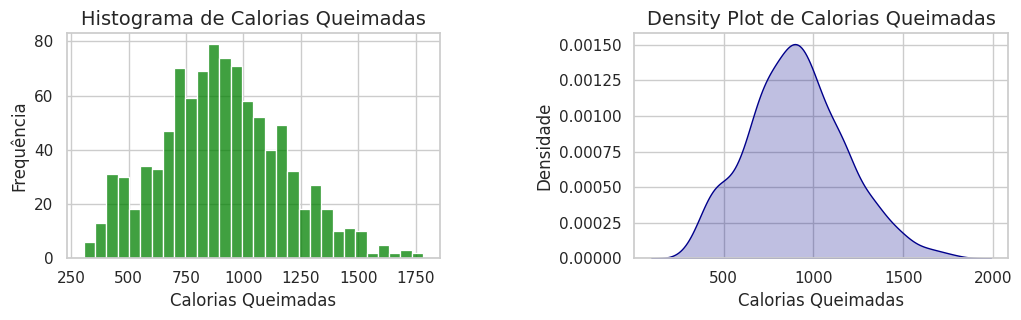

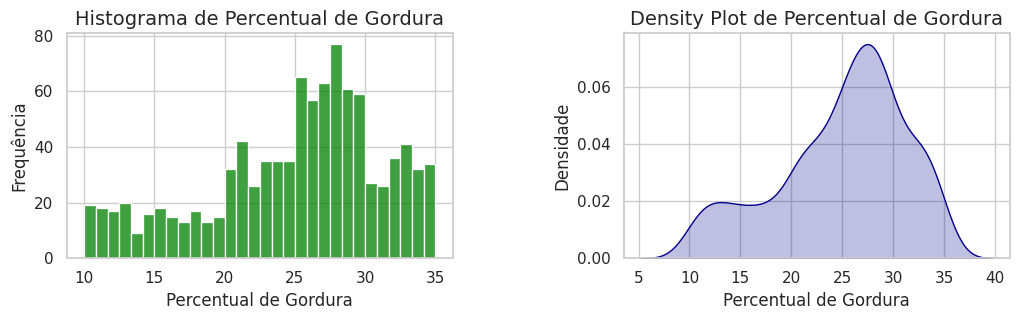

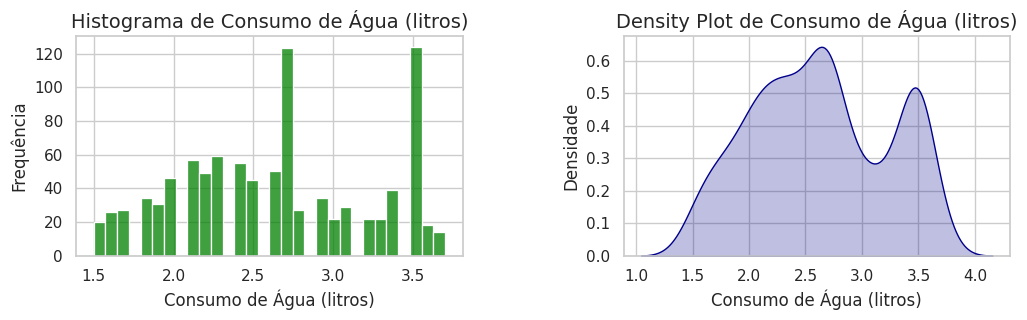

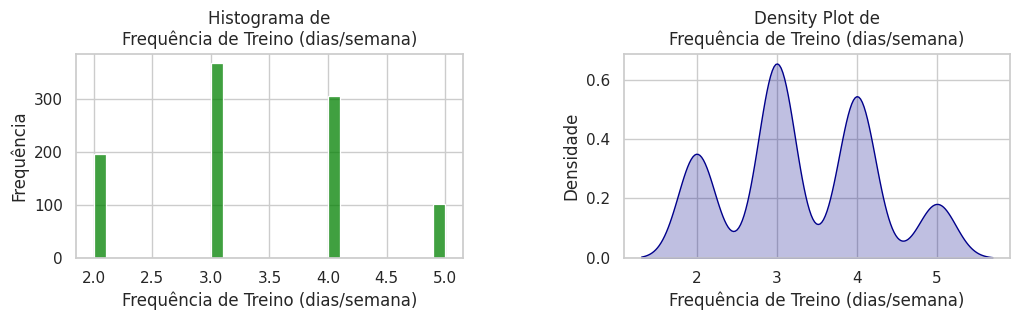

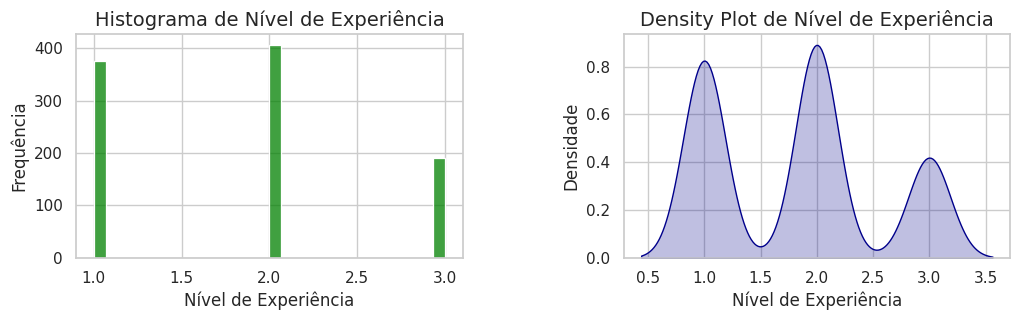

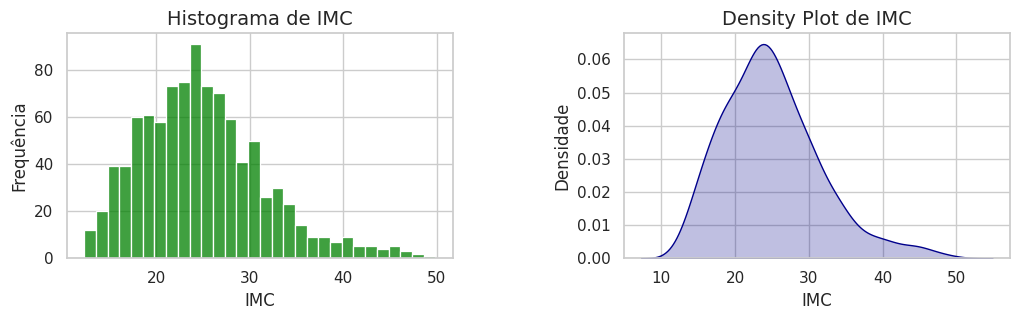

In [31]:
# Criando histogramas e gráficos de distribuição de densidade
hist_density(df_numerico, hist_color='green', kde_color='darkblue')

Pode-se verificar que grande parte dos atributos possui uma distribuição do tipo normal. No processo de transformação dos dados, essa informação é importante. Em dados que possuem distribuição normal, aplicar a padronização dos mesmos é um processo recomendado no pré-processamento antes da aplicação do modelo de Machine Learning.

É construída também uma matriz de correlação de Pearson para ser possível verificar as correlações entre os atributos.

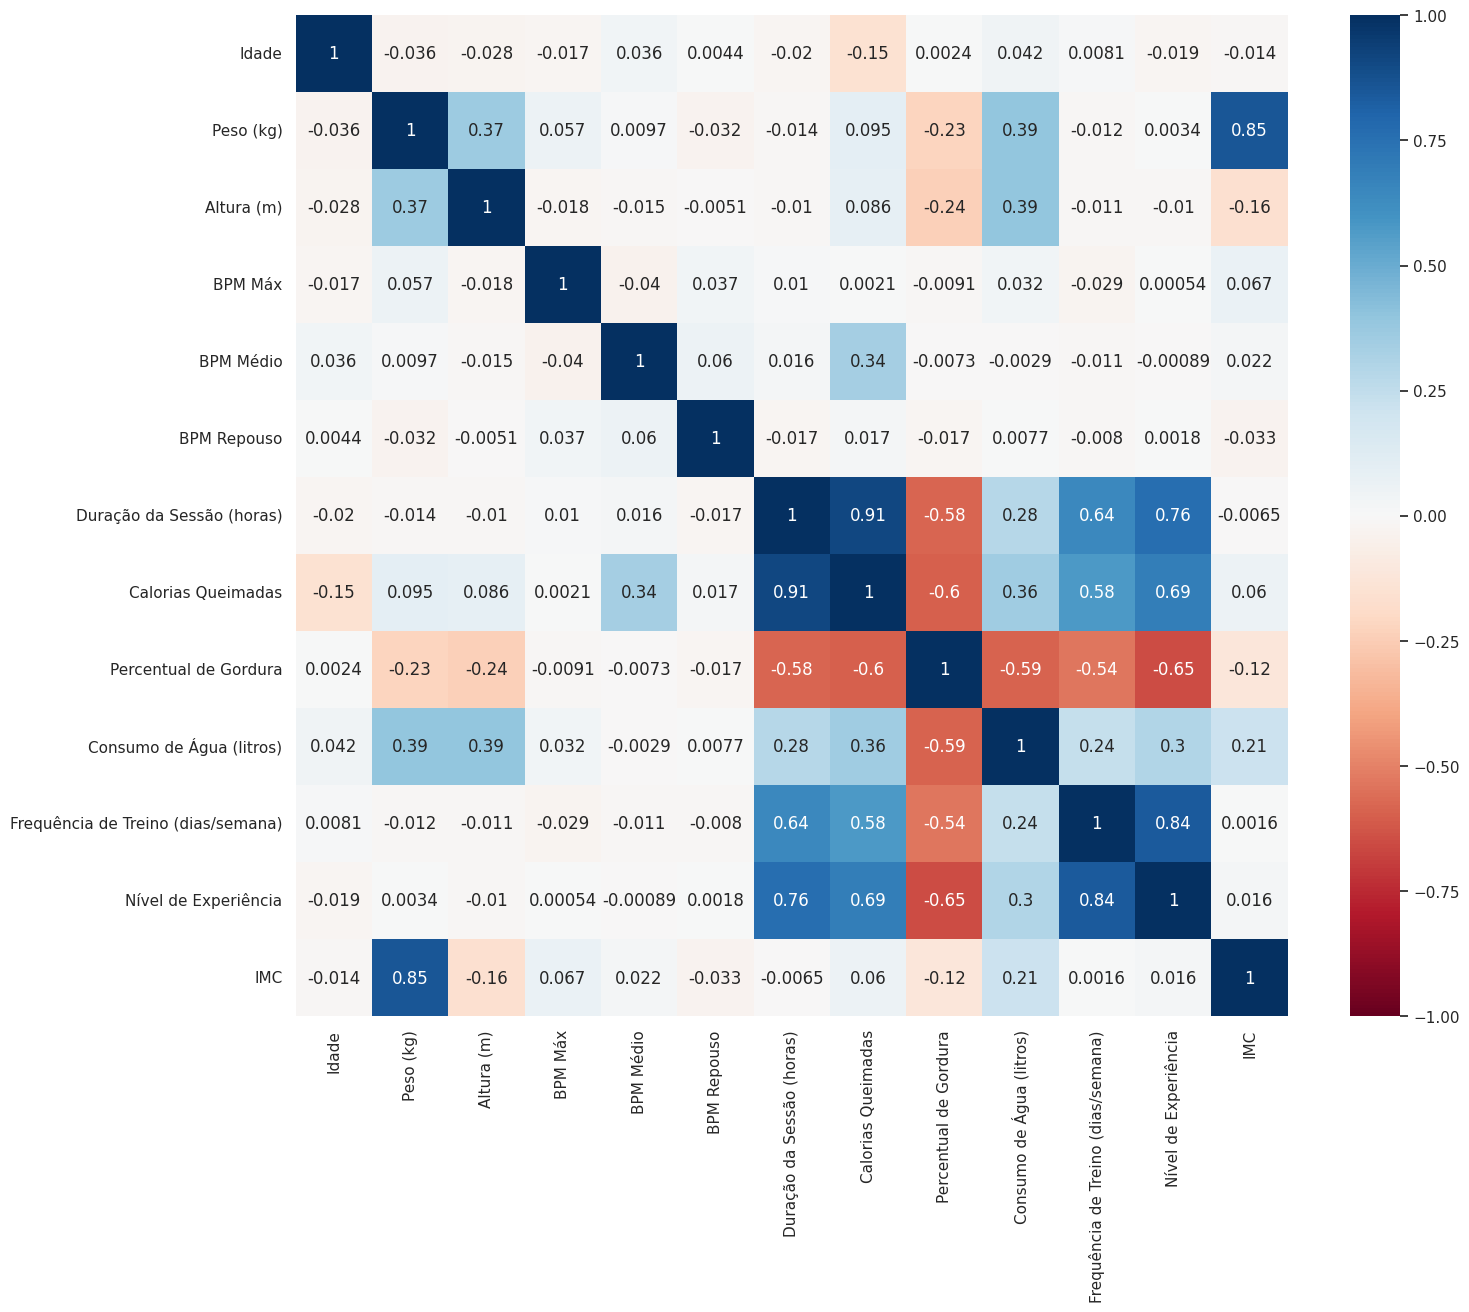

In [32]:
# Gerando a matriz de correlação de Pearson
plt.figure(figsize = (16,13))
sns.heatmap(df_numerico.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);

Analisando a matriz gerada, pode-se identificar algumas fortes correlações do atributo alvo (Calorias Queimadas) com os seguintes atributos preditores: Duração da Sessão (horas), Percentual de Gordura, Consumo de Água (litros), Frequência de Treino (dias/semana) e Nível de Experiência. Essa identificação é importante pois esses atributos devem fazer parte dos escolhidos para o treinamento dos modelos.

## Construção do Modelo de Machine Learning

Após a análise exploratória dos dados, é iniciado o processo de construção do modelo de Machine Learning para solução do problema. A primeira etapa consiste em separar os dados e prepará-los para utilização dos mesmos nos algoritmos.

### Separação dos dados, pré-processamento e divisão dos conjuntos de treino e teste

Os dados são divididos em bases de treino e teste. Foi escolhida uma divisão da base de dados em 80% para treino e 20% para teste.
O atributo categórico "Gênero" foi considerado nesse processo de divisão, que é realizada de forma que as classes "Masculino" e "Feminino" estejam distribuídas uniformemente entre as bases de treino e teste, reduzindo o risco de viés causado por desequilíbrio entre as bases.

In [33]:
# Divisão das matrizes
X = dataframe.drop(columns=['Calorias Queimadas'])  # Atributos de predição
y = dataframe['Calorias Queimadas']                 # Atributo alvo

# Garantir a presença do atributo "Gênero"
if 'Gênero' not in X.columns:
    raise ValueError("O atributo 'Gênero' deve estar"
                     "presente no conjunto de dados."
                    )

# Dividir em treino e teste com estratificação no atributo "Gênero"
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=X['Gênero']
                                                    )

# Verificar a distribuição do atributo "Gênero" em treino e teste
print("Distribuição em X_train:")
print(X_train['Gênero'].value_counts(normalize=True))

print("\nDistribuição em X_test:")
print(X_test['Gênero'].value_counts(normalize=True))

Distribuição em X_train:
Gênero
Masculino    0.525707
Feminino     0.474293
Name: proportion, dtype: float64

Distribuição em X_test:
Gênero
Masculino    0.523077
Feminino     0.476923
Name: proportion, dtype: float64


Após esse processo, é aplicado o One Hot Encoder para transformar as classes dos atributos categóricos em valores numéricos, de modo a ser possível aplicar os modelos de machine learning com esses dados, já que os algoritmos só podem ser executados com dados númericos.

In [35]:
categorical_columns = ['Gênero', 'Tipo de Treino']

X_train_final, X_test_final = apply_one_hot_encoding(
    X_train,
    X_test,
    categorical_columns
    )

print("Base de treino (X_train):")
print(X_train_final.head())

print("\nBase de teste (X_test):")
print(X_test_final.head())

Base de treino (X_train):
     Idade  Peso (kg)  Altura (m)  BPM Máx  BPM Médio  BPM Repouso  \
22      50       71.0        1.68      187        161           70   
749     28       79.6        1.59      181        130           54   
551     30      113.4        1.91      177        137           54   
183     19       87.8        1.78      195        161           72   
277     50       51.5        1.71      199        155           64   

     Duração da Sessão (horas)  Percentual de Gordura  \
22                        1.17                   33.1   
749                       1.49                   28.2   
551                       1.27                   22.2   
183                       1.28                   23.6   
277                       1.48                   20.9   

     Consumo de Água (litros)  Frequência de Treino (dias/semana)  \
22                        2.5                                   2   
749                       1.5                                   3   
551

### Métricas de Avaliação

Para métricas de avaliação dos modelos, foram definidas a Raiz do Erro Quadrático Médio (RMSE) e o Erro Médio Absoluto (MAE). O resultado dessas métricas serão comparados entre si para verificar a influência dos outliers nos resultados dos modelos.

### Seleção dos atributos para construção dos modelos (Feature Selection)

Após a divisão das bases de treino e teste, além da transformação das classes dos atriutos categóricos, o conjunto de treino é aplicado em vários modelos de regressão.

Antes do treinamento dos modelos, é realizada uma seleção dos melhores atributos para treinamento atrávés do algoritmo de feature selection. Nesse processo, foi escolhido o método da validação cruzada para o treinamento desses modelos com um número de k-folds igual a 10. Foram escolhidos para esse processo três modelos: Árvore de Regressão (Decision Tree Regressor), Floresta Aleatória (Random Forest Regressor) e Regressão Linear (Linear Regressor). Foi escolhido realizar a padronização dos dados antes da aplicação dos modelos. Ao final desse processo, será definido o modelo que melhor desempenhou em relação às métricas de avaliação, o número de atributos selecionados e quais são eles. Eles serão armazenados numa variável que será utilizada posteriormente no treinamento dos modelos para o problema.

In [36]:
# Definir os modelos
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'LinearRegression': LinearRegression()
}

# Intervalo de features
k_values = range(5, X_train_final.shape[1] + 1)

# Escalonador
scaler = StandardScaler()

# Executar a função
final_results, best_k, best_features = feature_selection_and_model_evaluation(
    X_train=X_train_final,
    y_train=y_train,
    X_test=X_test_final,
    y_test=y_test,
    models=models,
    k_values=k_values,
    cv=10,
    scaler=scaler,
    random_state=42
)

# Exibir resultados
print("Melhor modelo:", final_results['best_model'])
print("Melhores atributos selecionados:", final_results['best_features'])
print("Melhor valor de k (atributos selecionados):", final_results['best_k'])
print("Erro RMSE no conjunto de teste:", final_results['test_rmse'])
print("Erro MAE no conjunto de teste:", final_results['test_mae'])

Melhor modelo: LinearRegression
Melhores atributos selecionados: Index(['Idade', 'Altura (m)', 'BPM Máx', 'BPM Médio', 'BPM Repouso',
       'Duração da Sessão (horas)', 'Percentual de Gordura',
       'Consumo de Água (litros)', 'Frequência de Treino (dias/semana)',
       'Nível de Experiência', 'IMC', 'Gênero_Feminino', 'Gênero_Masculino',
       'Tipo de Treino_Cardio', 'Tipo de Treino_Força', 'Tipo de Treino_HIIT',
       'Tipo de Treino_Yoga'],
      dtype='object')
Melhor valor de k (atributos selecionados): 17
Erro RMSE no conjunto de teste: 43.31262749708687
Erro MAE no conjunto de teste: 31.966227528143214


Com base nesse processo, o modelo de Regressão Linear foi o com melhor desempenho na escolha dos melhores atributos para o problema. Foram selecionados 17 atributos, listados no resultado conforme visto. Essas informações serão utilizados nos próximos passos da modelagem.

O uso da base de teste foi restrito a uma única etapa no fluxo de trabalho — a avaliação do desempenho final do modelo. Esse processo garante que o treinamento dos modelos no processo de seleção das features foi realizado de maneira justa e imparcial, sem risco de data leakage.

### Treinamento nos modelos

Com a definição dos melhores atributos no dataset, é realizado o treinamento do modelo para solução do problema de predição das Calorias Queimadas.

Serão treinados vários tipos de modelos de regressão para esse problema. São comparados os resultados para cada modelo em três cenários: dados originais, dados transformados com normalização e dados transformados com padronização.
Após o treinamento dos mesmos, serão comparados em relação às métricas de avaliação para escolha dos melhores modelos para o problema. Nesse processo inicial, é utilizada validação cruzada com k-fold = 10. Os modelos são definidos numa lista, são definidos os três cenários de formato dos dados e em seguida é chamada a função que realiza esse processo de treinamento, fornecendo os resultados no fim do processo.

In [37]:
# Lista de modelos de regressão
models = {
    'Regressão Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Árvore de Decisão': DecisionTreeRegressor(random_state=42),
    'KNN Regressor': KNeighborsRegressor(),
    'SVR': SVR()
}

# Escalonadores
scalers = {
    'Atributos Originais': None,
    'Com Normalização': MinMaxScaler(),
    'Com Padronização': StandardScaler()
}

# Avaliar modelos utilizando as features selecionadas
results_df, all_cv_results_df = evaluate_models_on_training(
    X_train_final,
    y_train, models,
    scalers,
    best_features,
    cv=10,
    random_state=42
)


Cenário: Atributos Originais

Modelo: Regressão Linear
RMSE CV: 39.2366, Desvio: 4.6762, MAE CV: 29.8205, Desvio MAE: 2.4831

Modelo: Ridge
RMSE CV: 39.5101, Desvio: 4.6114, MAE CV: 29.9590, Desvio MAE: 2.2532

Modelo: Lasso
RMSE CV: 39.4921, Desvio: 4.6771, MAE CV: 29.7959, Desvio MAE: 2.2973

Modelo: ElasticNet
RMSE CV: 154.4622, Desvio: 8.3285, MAE CV: 122.5700, Desvio MAE: 6.5137

Modelo: Random Forest
RMSE CV: 45.5768, Desvio: 4.9170, MAE CV: 34.8334, Desvio MAE: 3.2322

Modelo: Gradient Boosting
RMSE CV: 21.6478, Desvio: 4.0680, MAE CV: 15.7772, Desvio MAE: 1.9517

Modelo: Árvore de Decisão
RMSE CV: 72.6061, Desvio: 8.1027, MAE CV: 53.1263, Desvio MAE: 5.3038

Modelo: KNN Regressor
RMSE CV: 201.7634, Desvio: 11.3045, MAE CV: 160.5798, Desvio MAE: 10.1817

Modelo: SVR
RMSE CV: 269.7419, Desvio: 23.6684, MAE CV: 214.4809, Desvio MAE: 18.9548

Cenário: Com Normalização

Modelo: Regressão Linear
RMSE CV: 39.2250, Desvio: 4.6635, MAE CV: 29.8271, Desvio MAE: 2.4889

Modelo: Ridge
RMS

A partir dos resultados obtidos nos treinamentos dos modelos selecionados, pode-se construir um gráfico onde é possível visualizar como estão distribuídos os resultados dos cinco melhores modelos em relação aos valores das métricas definidas (MSE - Erro Médio Quadrático e MAE - Erro Médio Absoluto).

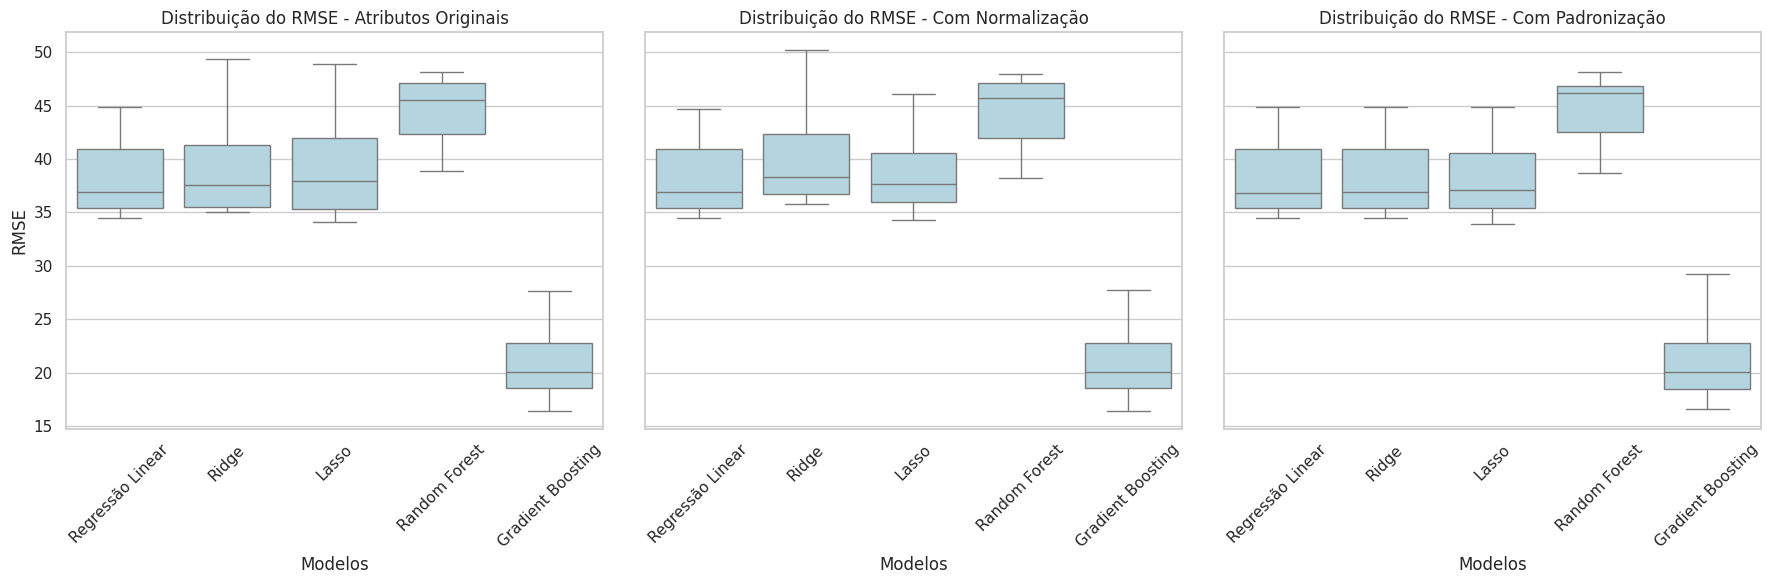

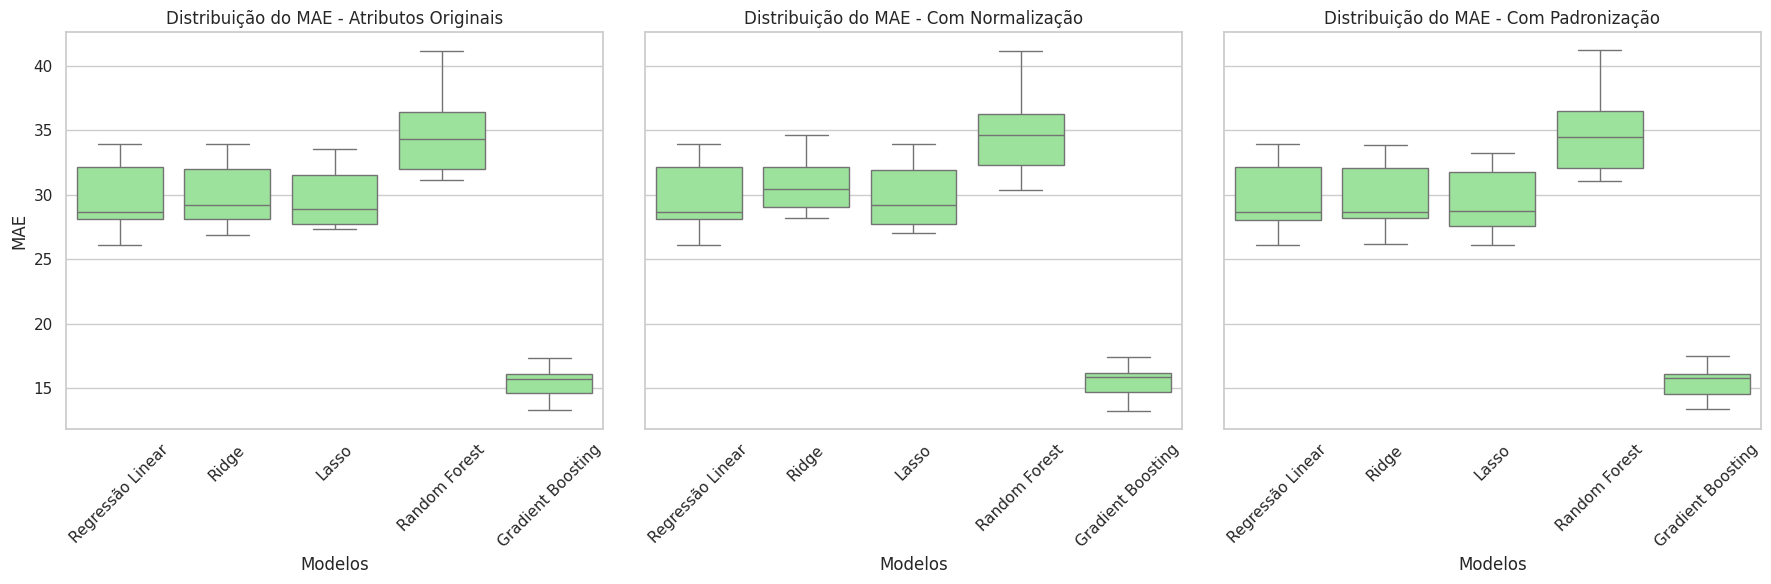

In [38]:
# Lista com os cenários analisados
cenarios = ['Atributos Originais', 'Com Normalização', 'Com Padronização']

# Chamada da função de construção dos gráficos para os melhores modelos
gerar_graficos_boxplot(all_cv_results_df, cenarios)

É possível verificar que o Modelo Gradient Boosting Regressor apresentou o menor valor em ambas as métricas. Nos três cenários os valores ficaram bem próximos. A partir disso, são escolhidos os 5 melhores modelos no geral, englobando todos os cenários de transformação dos dados. Eles serão a base para a escolha do modelo definitivo.
Após essa escolha, são plotadas as curvas de aprendizado desses melhores modelos.

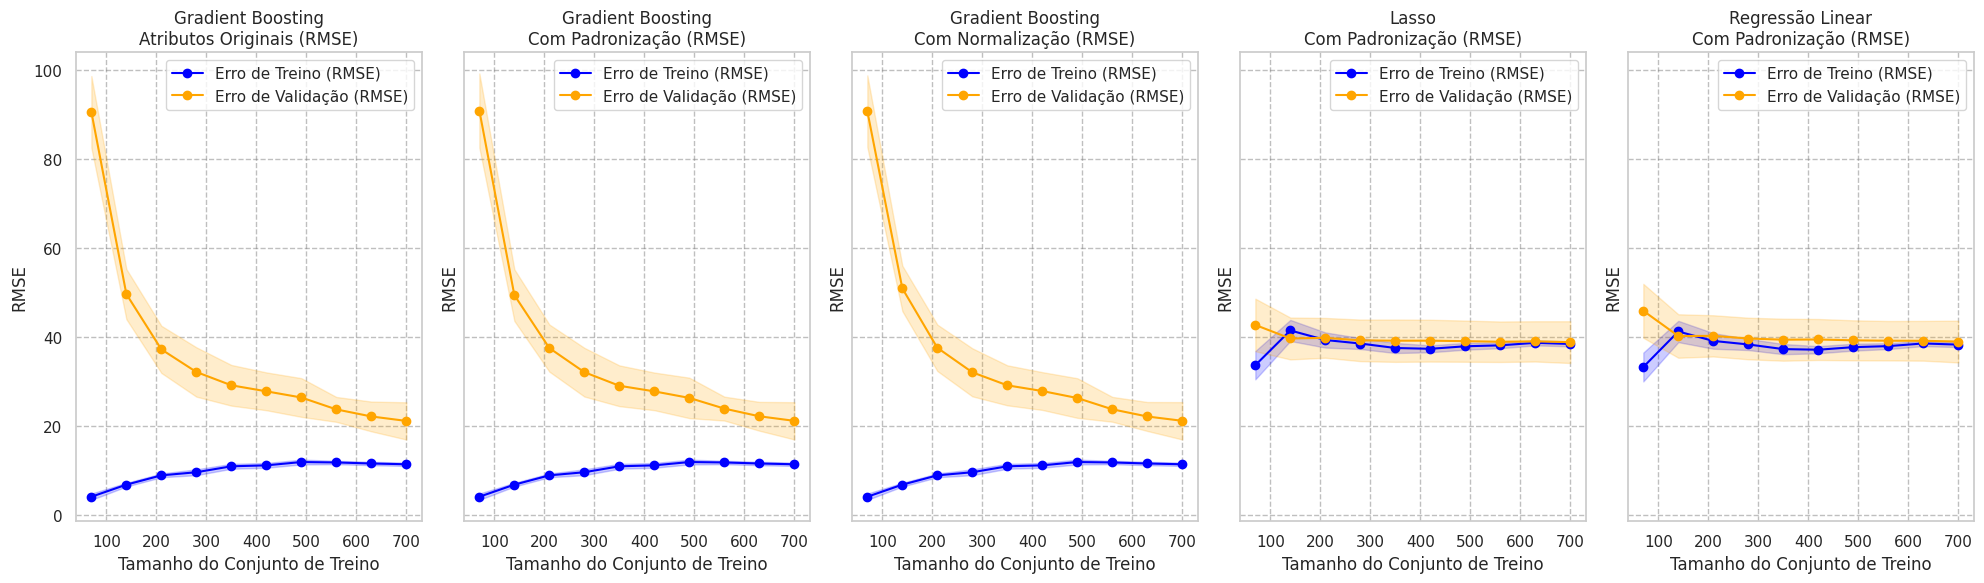

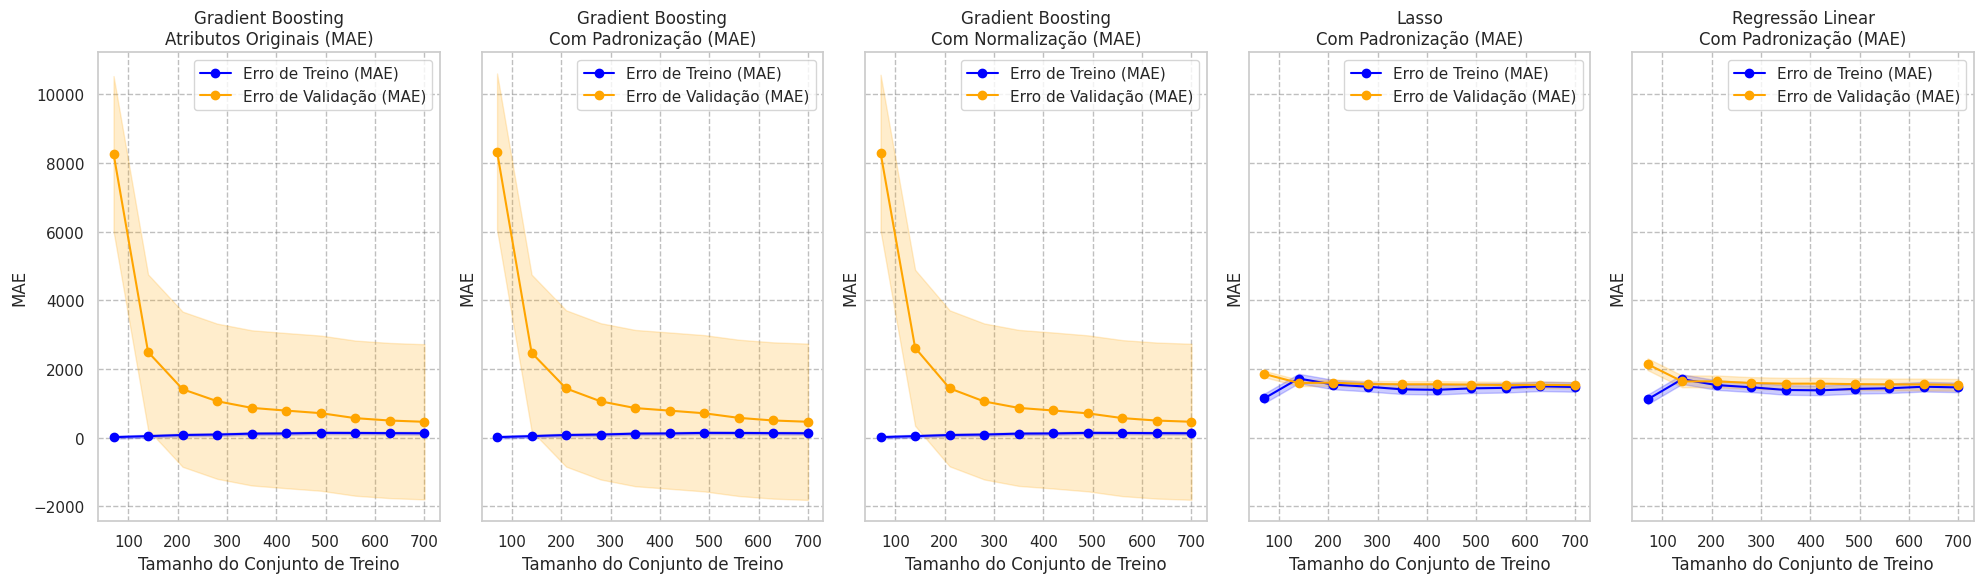

In [39]:
# Filtrar os 5 melhores modelos com base nas métricas
top_5_models = results_df.head(5)

# Plotar as curvas de aprendizado para os 5 melhores
plot_learning_curves(
    X_train_final,
    y_train,
    models,
    scalers,
    best_features,
    top_5_models,
    cv=10,
    random_state=42
    )

Algumas informações podem ser obtidos a partir da análise dessas curvas:


*   Os 5 melhores modelos considerados foram: Gradient Boosting nos três cenários (Atributos Originais, com Normalização, com Padronização); Regressão Linear com Padronização e Regressão Linear Lasso com Padronização.
*   Esses melhores modelos não apresentaram underfitting, pois os erros de validação diminuem com o aumento dos subconjuntos de treino definidos no processo.
*   Pode-se indentificar que pela métrica MAE (Erro Médio Absoluto) os modelos desempenham melhor. Tal fato pode ser explicado pela presença de outliers nos atributos Peso (kg) e Calorias Queimadas (atributo alvo). O RMSE penaliza mais os modelos com outliers.

Análises complementares serão realizadas após a otimização dos hiperparâmetros para esses 5 modelos que tiveram melhor desempenho nas métricas.





### Otimização dos hiperparâmetros e aplicação na base de treino para os modelos selecionados

Após o treinamento dos modelos e seleção dos 5 melhores, é realizada uma otimização dos hiperparâmetros relacionados aos mesmos, de modo a se obter o melhor desempenho possível. Nesse processo é utilizada a biblioteca Gridsearch.
Foram definidos alguns hiperparâmetros para cada modelo e a partir deles os melhores serão selecionados. É importante ressaltar que quando maior o número de hiperparâmetros definidos, maior é o tempo de processamento para obtenção do resultado. Desse modo, não serão testadas todas as possibilidades, mas somente uma quantidade suficiente para um bom desempenho do modelo em relação ao tempo de processamento utilizado para tal.

A célula a seguir possui um tempo longo de processamento, para seguir a execução do Notebook de modo rápido e otimizado, o resultado do Grid Search foi salvo no repositório e pode ser carregado através de um comando mais adiante neste projeto.

In [ ]:
# Aplicar Grid Search nos 5 melhores modelos
optimized_results_df = apply_grid_search_top_5(
    X_train_final=X_train_final,
    y_train=y_train,
    best_features=best_features,
    models=models,
    scalers=scalers,
    results_df=results_df,
    random_state=42
)

# Exibir os resultados otimizados
print("\nResultados Otimizados dos 5 Melhores Modelos:")
print(optimized_results_df)
optimized_results_df.sample(5)


Aplicando Grid Search no modelo: Gradient Boosting com escalonador: Atributos Originais
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Aplicando Grid Search no modelo: Gradient Boosting com escalonador: Com Padronização
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Aplicando Grid Search no modelo: Gradient Boosting com escalonador: Com Normalização
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Aplicando Grid Search no modelo: Lasso com escalonador: Com Padronização
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Aplicando Grid Search no modelo: Regressão Linear com escalonador: Com Padronização
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Resultados:
{'Modelo': 'Gradient Boosting', 'Cenário': 'Atributos Originais', 'Melhor MAE': 13.596948348961979, 'Melhor RMSE': 18.456069428624716, 'Melhores Hiperparâmetros': {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_est

,Modelo,Cenário,Melhor MAE,Melhor RMSE,Melhores Hiperparâmetros
4,Regressão Linear,Com Padronização,30.119225,39.457377,{}
1,Gradient Boosting,Com Padronização,13.780785,18.852445,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa..."
0,Gradient Boosting,Atributos Originais,13.596948,18.456069,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa..."
2,Gradient Boosting,Com Normalização,13.314512,18.077053,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa..."
3,Lasso,Com Padronização,29.751295,39.426747,{'alpha': 1.9306977288832496}


In [ ]:
# Salvando o dataframe com os melhores hiperparâmetros
# Convertendo a coluna 'Melhores Hiperparâmetros' para
# strings JSON antes de salvar
optimized_results_df['Melhores Hiperparâmetros'] = (
    optimized_results_df['Melhores Hiperparâmetros'].apply(json.dumps)
    )
optimized_results_df.to_csv('optimized_results_df.csv', index=False)

Para a execução do Notebook ser mais rápida a eficiente, foi salvo no repositório o dataframe "optimized_results_df", que contém a informações dos modelos com seus respectivos melhores hiperparâmetros. Basta continuar a execução do programa a partir desta célula que o processo seguirá sem erros.

In [43]:
# Carregando o dataframe com os melhores hiperparâmetros a partir
# do repositório
url = (
    "https://raw.githubusercontent.com/MarcelLopes7/"
    "Machine-Learning-and-Analytics/refs/heads/main/optimized_results_df.csv"
)
optimized_results_df = pd.read_csv(url)

# Convertendo a coluna 'Melhores Hiperparâmetros'
# de strings JSON para dicionários
optimized_results_df['Melhores Hiperparâmetros'] = \
    optimized_results_df['Melhores Hiperparâmetros'].apply(json.loads)

# Exibindo o dataframe com os melhores hiperparâmetros
pd.set_option('display.max_colwidth', None)
optimized_results_df.sample(5)

,Modelo,Cenário,Melhor MAE,Melhor RMSE,Melhores Hiperparâmetros
3,Lasso,Com Padronização,29.751295,39.426747,"{'alpha': 1.9306977288832496, 'random_state': 42}"
2,Gradient Boosting,Com Normalização,13.314512,18.077053,"{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.7, 'random_state': 42}"
1,Gradient Boosting,Com Padronização,13.780785,18.852445,"{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8, 'random_state': 42}"
4,Regressão Linear,Com Padronização,30.119225,39.457377,{}
0,Gradient Boosting,Atributos Originais,13.596948,18.456069,"{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.7, 'random_state': 42}"


Pode-se inferir que com a otimização dos hiperparâmetros, foi possível diminuir um pouco mais o erro em comparação com o processo anterior.
São traçadas a seguir as curvas de aprendizado após a seleção dos hiperparâmetros, ou seja, a partir do treinamento dos modelos com esses hiperparâmetros ótimos definidos.

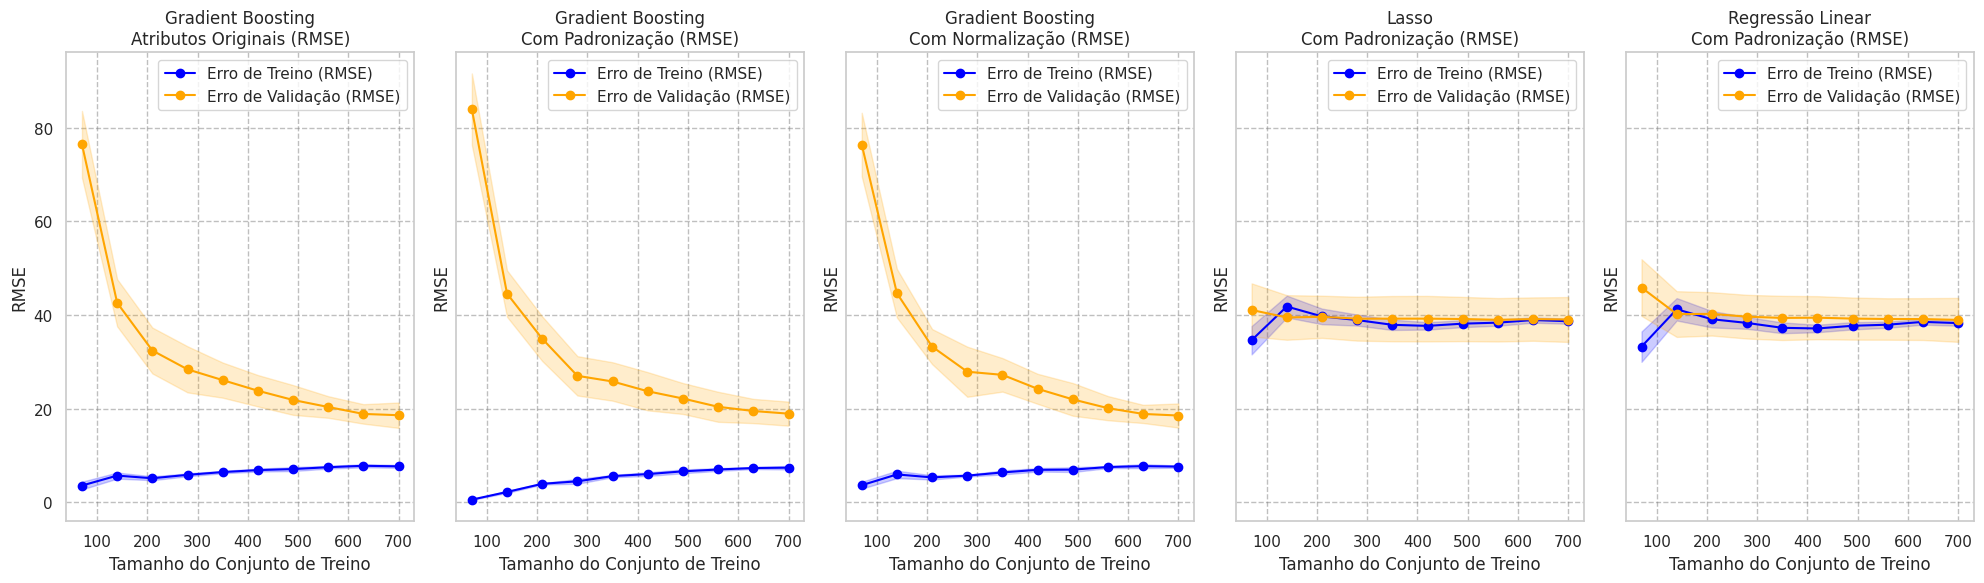

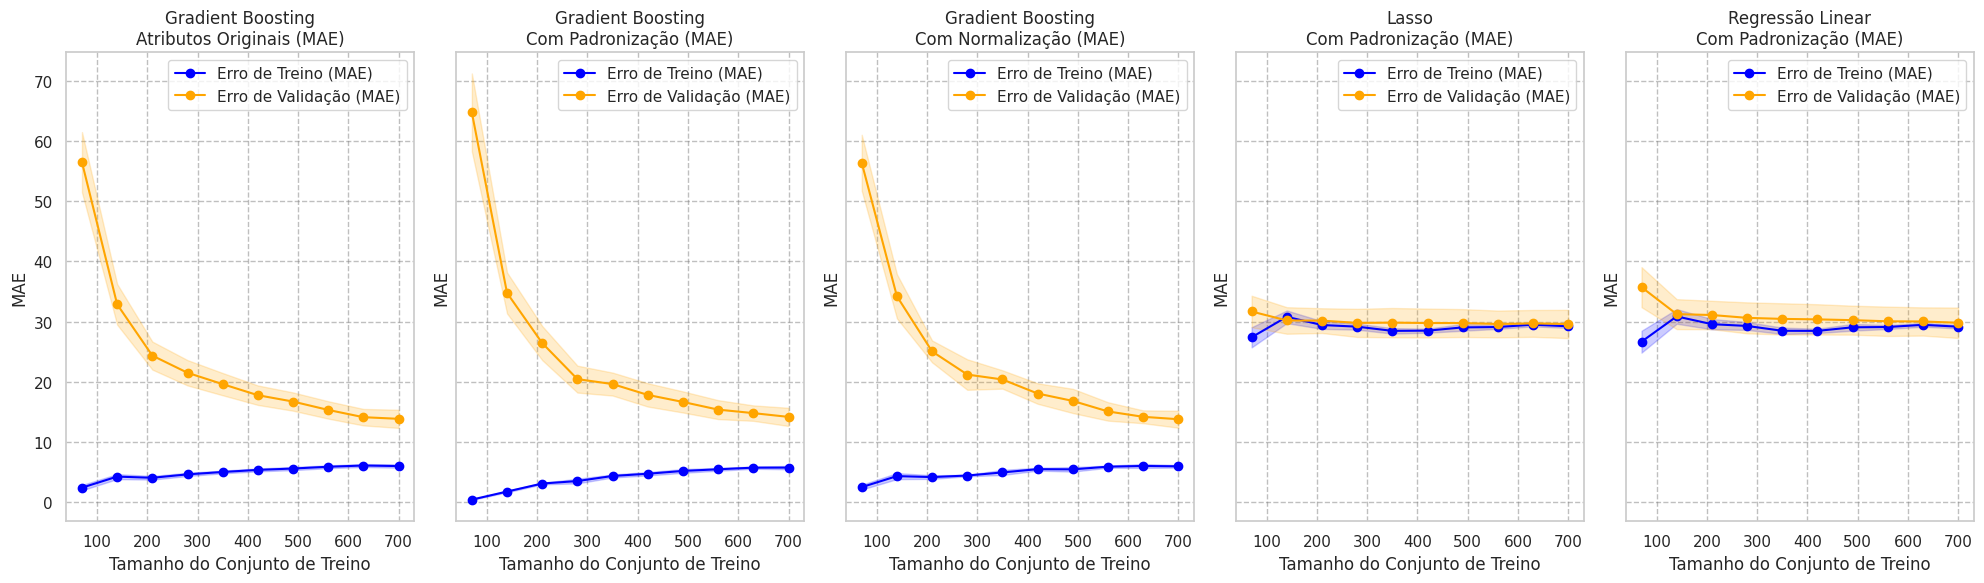

In [44]:
# Plotar as curvas de aprendizado para os 5 melhores modelos após o Grid Search
plot_learning_curves_post_grid_search(
    X_train=X_train_final,
    y_train=y_train,
    models=models,
    scalers=scalers,
    selected_features=best_features,
    grid_search_results_df=optimized_results_df,
    cv=10
)

Algumas informações podem ser obtidos a partir da análise dessas curvas:


*   Após aplicação dos hiperparâmetros, o MAE ficou um pouco mais elevado na validação para o Gradient Boosting em todos os cenários. Mesmo assim, a diferença é pequena e aceitável para o desempenho do modelo.
*   Não foram observadas outras variáções que indicassem piora no desempenho dos modelos, evidenciando assim que a seleção de hiperparâmetros é necessária para otimização em projetos de Machine Learning.




### Aplicação dos modelos na base de teste

A partir dos hiperparâmetros selecionados, os modelo são aplicados na base testes e são avaliadas as métricas de desempenho dos mesmos.

In [45]:
# Chamada da função para testar os modelos otimizados
test_results_df = testar_modelos_otimizados(
    X_train_final,
    y_train,
    X_test_final,
    y_test,
    optimized_results_df,
    models,
    scalers,
    best_features,
    random_state=42
)

# Exibir os resultados
print("\nResultados de RMSE e MAE no conjunto de teste:")
test_results_df.sample(5)


Testando o modelo: Gradient Boosting com escalonador: Atributos Originais

Testando o modelo: Gradient Boosting com escalonador: Com Padronização

Testando o modelo: Gradient Boosting com escalonador: Com Normalização

Testando o modelo: Lasso com escalonador: Com Padronização

Testando o modelo: Regressão Linear com escalonador: Com Padronização

Resultados de RMSE e MAE no conjunto de teste:


,Modelo,Cenário,RMSE no Teste,MAE no Teste
3,Lasso,Com Padronização,44.487632,32.168428
1,Gradient Boosting,Com Padronização,19.417542,14.163288
0,Gradient Boosting,Atributos Originais,19.824233,13.794330
2,Gradient Boosting,Com Normalização,20.123860,13.635444
4,Regressão Linear,Com Padronização,43.580327,32.223305


Foi identificado que todos os modelos obtiveram um desempenho satisfatório com o conjunto de teste. Devido a não elevação significativa do valor das métricas de desempenho, pode-se verificar que esse modelo não apresentou overfitting, que seria um ajuste em demasia aos dados de treino.

Esses resultados também podem ser comparados graficamente.

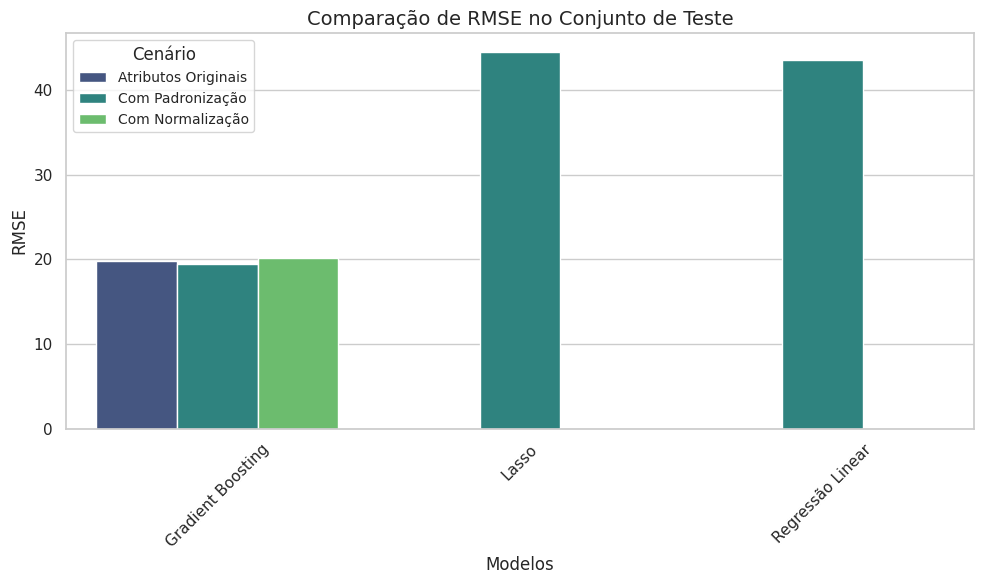

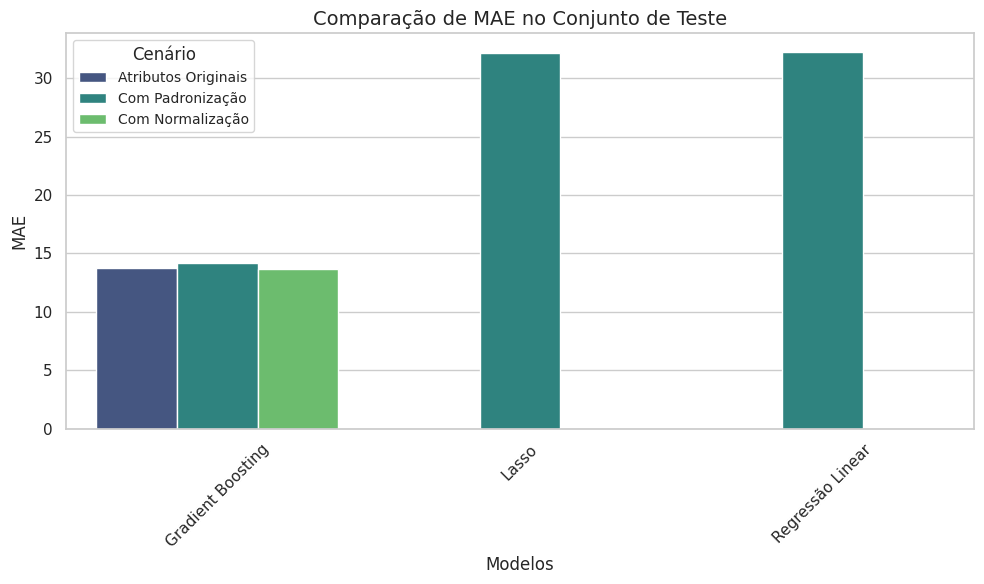

In [46]:
# Chame a função para plotar os gráficos de desempenho dos modelos
plot_model_performance(test_results_df)

Tendo em vista o desempenho de todos esses melhores modelos, foi escolhido o modelo Gradient Boosting com Padronização para ser o modelo definitivo, com o objetivo de aplicar em todo o dataset para ser salvo e posto em produção. O respectivo valor de RMSE é o mais baixo entre os modelos e uma métrica que penalizaria os outliers, mas como seu valor ficou baixo, significa que o desempenho do modelo foi satisfatório.

### Aplicação do modelo escolhido com novos dados

Com a definição do modelo para o problema, o mesmo será salvo e aplicado com novos dados que serão inseridos manualmente como forma de verificar a funcionalidade do modelo.

In [51]:
# Função que treina todo o dataset com o modelo escolhido
best_model, cv_rmse_mean, cv_mae_mean = treinar_modelo_mais_eficiente(
    test_results_df,
    optimized_results_df,
    X_train_final,
    y_train,
    X_test_final,
    y_test,
    models,
    scalers,
    best_features
)


Modelo escolhido: Gradient Boosting com escalonador: Com Padronização

Melhores Hiperparâmetros encontrados: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8, 'random_state': 42}

Modelo Gradient Boosting treinado com sucesso nos dados completos com os seguintes hiperparâmetros:
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8, 'random_state': 42}

Desempenho final do modelo Gradient Boosting:
RMSE médio (validação cruzada): 16.21
MAE médio (validação cruzada): 12.16

Modelo salvo como 'modelo_final.pkl'


O modelo escolhido foi treinado com todo o dataset e salvo no final do processo. Pode-se verificar que os resultados das métricas de avaliação foram menores que o registrado anteriormente, o que indica que o modelo pode ser validado.

A seguir, são listadas 4 novas instâncias com seus respectivos atributos. Os valores dessas instâncias foi pensado sem utilizar valores idênticos aos das instâncias do dataset, de modo que o modelo seja aplicado nesses dados não vistos.

In [52]:
# Carregar o modelo salvo
best_model = joblib.load('modelo_final.pkl')
print("\nModelo carregado com sucesso.")

# Exemplo de novos dados
new_data = pd.DataFrame({
    'Idade': [25, 35, 39, 28],
    'Peso (kg)': [75.4, 55.3, 65.3, 61.4],
    'Altura (m)': [1.82, 1.67, 1.70, 1.63],
    'BPM Máx': [193, 189, 192, 188],
    'BPM Médio': [147, 153, 138, 135],
    'BPM Repouso': [64, 70, 69, 62],
    'Duração da Sessão (horas)': [1.5, 1.2, 1.3, 0.8],
    'Percentual de Gordura': [22.3, 17.2, 15.3, 20.2],
    'Consumo de Água (litros)': [2.4, 2.1, 2.9, 1.5],
    'Frequência de Treino (dias/semana)': [3, 4, 4, 2],
    'Nível de Experiência': [2, 3, 2, 1],
    'IMC': [22.64, 19.82, 22.59, 23.11],
    'Gênero': ['Masculino', 'Feminino', 'Feminino', 'Feminino'],
    'Tipo de Treino': ['Força', 'HIIT', 'Cardio', 'Yoga']
})

# Aplicar One-Hot Encoding nos novos dados
new_data_final, encoder = apply_one_hot_encoding_for_new_data(
    X_new=new_data,
    categorical_columns=['Gênero', 'Tipo de Treino']
)

# Selecionar as mesmas features usadas no treinamento
new_data_final = new_data_final[best_features]

# Escalonar os novos dados
new_data_scaled = apply_scaler_for_new_data(
    X_new=new_data_final,
    scaler=scaler,  # O mesmo escalonador utilizado no treinamento
    best_features=best_features  # As melhores features no treinamento
)

# Exibir os dados escalonados
print("Novos Dados (após escalonamento):")
print(new_data_scaled)

# Fazer previsões nos novos dados
predictions = best_model.predict(new_data_scaled)

# Arredondar as previsões para 2 casas decimais
predictions_arredondadas = [round(pred, 2) for pred in predictions]

# Exibir as previsões com duas casas decimais
print("\nPrevisões de Calorias Queimadas para os novos dados:")
print(predictions_arredondadas)


Modelo carregado com sucesso.
Novos Dados (após escalonamento):
      Idade  Altura (m)   BPM Máx  BPM Médio  BPM Repouso  \
0 -1.218493    1.622295  1.212678   0.524142    -0.672692   
1  0.586682   -0.493742 -0.727607   1.362770     1.121153   
2  1.308752   -0.070535  0.727607  -0.733799     0.822179   
3 -0.676941   -1.058018 -1.212678  -1.153113    -1.270640   

   Duração da Sessão (horas)  Percentual de Gordura  Consumo de Água (litros)  \
0                   1.176697               1.318210                  0.345285   
1                   0.000000              -0.575556                 -0.246632   
2                   0.392232              -1.281077                  1.331812   
3                  -1.568929               0.538424                 -1.430465   

   Frequência de Treino (dias/semana)  Nível de Experiência       IMC  \
0                           -0.301511              0.000000  0.462367   
1                            0.904534              1.414214 -1.710757   
2   

O modelo treinado foi capaz de prever valores de Calorias Queimadas a partir de novos dados de entrada.

## Considerações finais

Desse modo, nesse MVP foi possível realizar a construção de um modelo de Machine Learning para a solução do problema de previsão das Calorias Queimadas, conforme descrito na introdução. O processo foi assim: seleção dos melhores atributos; teste dos diversos modelos de regressão e comparados seus desempenhos a partir das métricas de avaliação definidas; selecionados os 5 melhores modelos com base nas métricas; testados e selecionados os melhores hiperparâmetros para esses modelos; os modelos foram aplicados na base de teste e foi escolhido o com menor valor na métrica especificada; inserção de novos dados e predição a partir do modelo treinado.

Conforme as métricas definidas, não foi verificado underfitting no treinamento e também não foi verificado overfitting quando os desempenhos dos melhores modelos na base de teste foram comparados aos de treino. Isso contribui para que o modelo fosse validado conforme o processo construído nesse MVP.

A partir desses resultados, é sugerido variar a possibilidade de hiperparâmetros para entender o ajuste dos modelos a isso e também modificar o problemas para previsão de outras variáveis alvo, utilizando a mesma lógica e processo desse problema.